# Preparation

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
from functions import *

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
import shap
import random
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_validate, cross_val_predict

/opt/anaconda3/envs/openclassrooms/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [4]:
def split_and_miss(df):
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    imp = SimpleImputer(strategy='median')
    imp.fit(X_train)
    X_train_full = imp.transform(X_train)
    X_test_full = imp.transform(X_test)
    feats1 = feats.remove('TARGET')
    X_train_full = pd.DataFrame(columns=feats, data=X_train_full)
    X_test_full = pd.DataFrame(columns=feats, data=X_test_full)
    y_train = y_train.reset_index().drop('index', axis=1)
    y_test = y_test.reset_index().drop('index', axis=1)
    
    return X_train_full, X_test_full, y_train, y_test

In [5]:
df = pd.read_csv('data_transformed.csv')

In [6]:
X_train, X_test, y_train, y_test = split_and_miss(df)

In [7]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [8]:
df_full = pd.read_csv('data_transformed_full.csv')

In [9]:
X_train_full, X_test_full, y_train_full, y_test_full = split_and_miss(df_full)

In [10]:
y_train_full = y_train_full.squeeze()
y_test_full = y_test_full.squeeze()

## Functions
### Score

In [11]:
from sklearn.metrics import make_scorer, confusion_matrix, SCORERS

def score_function(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    return len(y)/(10*cm[1][0] + cm[0][1])
custom_score = make_scorer(score_function, greater_is_better=True, needs_proba=False)

### Filter

In [12]:
def data_filtered(X, features_kept):
    
    X = X.loc[:, features_kept]
    return X

### Number of features

In [13]:
def num_features(X_train, y_train, model, num_folds):
    
    cv = StratifiedKFold(num_folds)
    scl = MinMaxScaler()
    estimator = model
    selector = RFECV(estimator=estimator,
                    step=1,
                    cv=cv,
                    scoring='roc_auc')
    
    pipe = make_pipeline(scl, selector)
    pipe.fit(X_train, y_train)
    
    result = selector.cv_results_
    print(f"Optimal number of features : {selector.n_features_}")
    return selector.cv_results_
 

In [14]:
def plot_num_features(result_df):
    print(f" Best mean test score : {max(result_df['mean_test_score'])} for {result_df.loc[result_df['mean_test_score']==max(result_df['mean_test_score'])].index[0]+1} features kept")
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].set_xlabel("Number of features selected")
    ax[0].set_ylabel("Cross validation score roc_auc")
    ax[0].plot( pd.DataFrame(result_df).iloc[:, 2:])
    ax[1].set_xlabel("Number of features selected")
    ax[1].set_ylabel("Mean roc_auc")
    ax[1].plot( pd.DataFrame(result_df).iloc[:, 0]);

### Features selection

In [15]:
def features_selection(X_train, y_train, model, nb_features):
    
    scl = MinMaxScaler()
    clf = RFE(estimator=model, n_features_to_select=nb_features, step=2, )
    steps = [('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    features = pd.DataFrame(X_train.columns)
    features_kept = features.loc[pipe['clf'].support_]
    return features_kept[0]

### Find best hyper parameters

In [16]:
def fine_tune_model(X_train, y_train, num_folds, model, features_kept, param_grid ):
    
    X_train = data_filtered(X_train, features_kept)
    
    cv = StratifiedKFold(num_folds)
    scl = MinMaxScaler()
    clf = model
    steps = [('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    search = GridSearchCV(pipe, param_grid, n_jobs=2, scoring="roc_auc", cv=cv)
    search.fit(X_train, y_train)
    
    print(f"Best parameters : {search.best_params_}")
    

### Find best threshold

In [17]:
def best_threshold(X_train, X_test, y_train, y_test, features_kept, num_folds, model, mini, maxi): 
    
    X_train, X_test = data_filtered(X_train, features_kept), data_filtered(X_test, features_kept)
    
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    scl = MinMaxScaler()
    clf = model
    steps = [('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    # Evaluation du model par cross validation
    cv_results = cross_validate(pipe, X_train, y_train, scoring='roc_auc', cv=folds, n_jobs=2, verbose=0, fit_params=None, return_train_score=True, return_estimator=True)
    results_df = pd.DataFrame(cv_results).loc[:, ['fit_time', 'score_time', 'test_score', 'train_score']].rename(columns={'test_score': 'validation_score'}).reset_index()
    results_df = results_df.rename(columns={'index':'folds'})
    mean = results_df.mean(axis=0)
    results_df = pd.concat([results_df, mean.to_frame().T], ignore_index=True)
    results_df.iloc[-1, 0] = 'mean'
    print(results_df)
        
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        clf_fold = cv_results['estimator'][n_fold]

        train_predict = pd.DataFrame(clf_fold.predict_proba(train_x)[: , 1])
        valid_predict = pd.DataFrame(clf_fold.predict_proba(valid_x)[: , 1])
    
        # Search for best threshold
        param = np.linspace(mini, maxi,  20)
        threshold = []
        cost = []
        for i in param: 
                train_predict_class = train_predict.applymap(lambda x: 1 if x>i else 0)
                cm = confusion_matrix(train_y, train_predict_class)
                ’’             
        ix = np.argmin(cost)
        threshold += [param[ix]]   
    best_threshold = (np.array(threshold)).mean()
        
    # entrainement et enregistrement du model
    pipe.fit(X_train, y_train)
    
    train_predict = pd.DataFrame(pipe.predict_proba(X_train)[: , 1])
    test_predict = pd.DataFrame(pipe.predict_proba(X_test)[: , 1])
    
    # roc_curve
    fpr, tpr, thresholds = roc_curve(y_train, train_predict)
    curve_train = RocCurveDisplay(fpr=fpr, tpr=tpr)
    fpr, tpr, thresholds = roc_curve(y_test, test_predict)
    curve_test = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    # Class prediction with best threshold
    train_predict_class = train_predict.applymap(lambda x: 1 if x>best_threshold else 0)
    cm_train = confusion_matrix(y_train, train_predict_class)
    cost_train = (10*cm_train[1][0] + cm_train[0][1])/len(y_train)*100
    test_predict_class = test_predict.applymap(lambda x: 1 if x>best_threshold else 0)
    cm_test = confusion_matrix(y_test, test_predict_class)
    cost_test = (10*cm_test[1][0] + cm_test[0][1])/len(y_test)*100
    
    # roc_curve with best threshold position
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    curve_train.plot(ax=ax[0])  
    curve_test.plot(ax=ax[1])
    ax[0].scatter(1-cm_train[0][0]/(cm_train[0][1]+cm_train[0][0]), cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]), marker='o', color='black', label='Best', linewidths=2)
    ax[1].scatter(1-cm_test[0][0]/(cm_test[0][1]+cm_test[0][0]), cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]), marker='o', color='black', label='Best', linewidths=2)
    ax[0].set_title('Train', weight='bold')
    ax[1].set_title('Test', weight='bold')
    
    # Confusion matrix
    confusion_train = ConfusionMatrixDisplay(cm_train)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_test.plot(ax=ax[1])
    
    print(f"\nBest threshold:\t{best_threshold}\n\nroc_auc train: \t{roc_auc_score(y_train, train_predict)} \nroc_auc test: \t{roc_auc_score(y_test, test_predict)}")
    print(f"Cost train : \t{cost_train}\nCost test: \t{cost_test}")
    
    return pipe
    
 

In [18]:
def best_threshold_no_scl(X_train, X_test, y_train, y_test, features_kept, num_folds, model, mini, maxi): 
    
    X_train, X_test = data_filtered(X_train, features_kept), data_filtered(X_test, features_kept)
    
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    clf = model
    steps = [('clf', clf)]
    pipe = Pipeline(steps)
    
    # Evaluation du model par cross validation
    cv_results = cross_validate(pipe, X_train, y_train, scoring='roc_auc', cv=folds, n_jobs=2, verbose=0, fit_params=None, return_train_score=True, return_estimator=True)
    results_df = pd.DataFrame(cv_results).loc[:, ['fit_time', 'score_time', 'test_score', 'train_score']].rename(columns={'test_score': 'validation_score'}).reset_index()
    results_df = results_df.rename(columns={'index':'folds'})
    mean = results_df.mean(axis=0)
    results_df = pd.concat([results_df, mean.to_frame().T], ignore_index=True)
    results_df.iloc[-1, 0] = 'mean'
    print(results_df)
        
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        clf_fold = cv_results['estimator'][n_fold]

        train_predict = pd.DataFrame(clf_fold.predict_proba(train_x)[: , 1])
        valid_predict = pd.DataFrame(clf_fold.predict_proba(valid_x)[: , 1])
    
        # Search for best threshold
        param = np.linspace(mini, maxi,  20)
        threshold = []
        cost = []
        for i in param: 
                train_predict_class = train_predict.applymap(lambda x: 1 if x>i else 0)
                cm = confusion_matrix(train_y, train_predict_class)
                cost += [(10*cm[1][0] + cm[0][1])/len(train_y)*100]              
        ix = np.argmin(cost)
        threshold += [param[ix]]   
    best_threshold = (np.array(threshold)).mean()
        
    # entrainement et enregistrement du model
    pipe.fit(X_train, y_train)
    
    train_predict = pd.DataFrame(pipe.predict_proba(X_train)[: , 1])
    test_predict = pd.DataFrame(pipe.predict_proba(X_test)[: , 1])
    
    # roc_curve
    fpr, tpr, thresholds = roc_curve(y_train, train_predict)
    curve_train = RocCurveDisplay(fpr=fpr, tpr=tpr)
    fpr, tpr, thresholds = roc_curve(y_test, test_predict)
    curve_test = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    # Class prediction with best threshold
    train_predict_class = train_predict.applymap(lambda x: 1 if x>best_threshold else 0)
    cm_train = confusion_matrix(y_train, train_predict_class)
    cost_train = (10*cm_train[1][0] + cm_train[0][1])/len(y_train)*100
    test_predict_class = test_predict.applymap(lambda x: 1 if x>best_threshold else 0)
    cm_test = confusion_matrix(y_test, test_predict_class)
    cost_test = (10*cm_test[1][0] + cm_test[0][1])/len(y_test)*100
    
    # roc_curve with best threshold position
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    curve_train.plot(ax=ax[0])  
    curve_test.plot(ax=ax[1])
    ax[0].scatter(1-cm_train[0][0]/(cm_train[0][1]+cm_train[0][0]), cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]), marker='o', color='black', label='Best', linewidths=2)
    ax[1].scatter(1-cm_test[0][0]/(cm_test[0][1]+cm_test[0][0]), cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]), marker='o', color='black', label='Best', linewidths=2)
    ax[0].set_title('Train', weight='bold')
    ax[1].set_title('Test', weight='bold')
    
    # Confusion matrix
    confusion_train = ConfusionMatrixDisplay(cm_train)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_test.plot(ax=ax[1])
    
    print(f"\nBest threshold:\t{best_threshold}\n\nroc_auc train: \t{roc_auc_score(y_train, train_predict)} \nroc_auc test: \t{roc_auc_score(y_test, test_predict)}")
    print(f"Cost train : \t{cost_train}\nCost test: \t{cost_test}")
    
    return pipe

In [19]:
def best_threshold_with_calibration(X_train, X_test, y_train, y_test, features_kept, num_folds, model, mini, maxi): 
    
    X_train, X_test = data_filtered(X_train, features_kept), data_filtered(X_test, features_kept)
    
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    scl = MinMaxScaler()
    clf = model
    regressor_calibrated = CalibratedClassifierCV(clf, method='isotonic', cv=3)
    
    steps = [('scl', scl), ('clf', clf)]
    steps_calib  = [('scl', scl), ('clf_calib', regressor_calibrated)]
    
    pipe = Pipeline(steps)
    pipe_calib = Pipeline(steps_calib)
    
    
    # Evaluation du model par cross validation
    cv_results = cross_validate(pipe_calib, X_train, y_train, scoring='roc_auc', cv=folds, n_jobs=2, verbose=0, fit_params=None, return_train_score=True, return_estimator=True)
    results_df = pd.DataFrame(cv_results).loc[:, ['fit_time', 'score_time', 'test_score', 'train_score']].rename(columns={'test_score': 'validation_score'}).reset_index()
    results_df = results_df.rename(columns={'index':'folds'})
    mean = results_df.mean(axis=0)
    results_df = pd.concat([results_df, mean.to_frame().T], ignore_index=True)
    results_df.iloc[-1, 0] = 'mean'
    print(results_df)
        
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        clf_fold = cv_results['estimator'][n_fold]

        train_predict = pd.DataFrame(clf_fold.predict_proba(train_x)[: , 1])
        valid_predict = pd.DataFrame(clf_fold.predict_proba(valid_x)[: , 1])
    
        # Search for best threshold
        param = np.linspace(mini, maxi,  20)
        threshold = []
        cost = []
        for i in param: 
                train_predict_class = train_predict.applymap(lambda x: 1 if x>i else 0)
                cm = confusion_matrix(train_y, train_predict_class)
                cost += [(10*cm[1][0] + cm[0][1])/len(train_y)*100]
                
        ix = np.argmin(cost)
        threshold += [param[ix]]   
    best_threshold = (np.array(threshold)).mean()
        
    # entrainement et enregistrement du model
    pipe.fit(X_train, y_train)
    pipe_calib.fit(X_train, y_train)
    
    train_predict = pd.DataFrame(pipe_calib.predict_proba(X_train)[: , 1])
    test_predict = pd.DataFrame(pipe_calib.predict_proba(X_test)[: , 1])
    
    # roc_curve
    fpr, tpr, thresholds = roc_curve(y_train, train_predict)
    curve_train = RocCurveDisplay(fpr=fpr, tpr=tpr)
    fpr, tpr, thresholds = roc_curve(y_test, test_predict)
    curve_test = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    # Class prediction with best threshold
    train_predict_class = train_predict.applymap(lambda x: 1 if x>best_threshold else 0)
    cm_train = confusion_matrix(y_train, train_predict_class)
    cost_train = (10*cm_train[1][0] + cm_train[0][1])/len(y_train)*100
    test_predict_class = test_predict.applymap(lambda x: 1 if x>best_threshold else 0)
    cm_test = confusion_matrix(y_test, test_predict_class)
    cost_test = (10*cm_test[1][0] + cm_test[0][1])/len(y_test)*100
    
    # roc_curve with best threshold position
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    curve_train.plot(ax=ax[0])  
    curve_test.plot(ax=ax[1])
    ax[0].scatter(1-cm_train[0][0]/(cm_train[0][1]+cm_train[0][0]), cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]), marker='o', color='black', label='Best', linewidths=2)
    ax[1].scatter(1-cm_test[0][0]/(cm_test[0][1]+cm_test[0][0]), cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]), marker='o', color='black', label='Best', linewidths=2)
    ax[0].set_title('Train', weight='bold')
    ax[1].set_title('Test', weight='bold')
    
    # Confusion matrix
    confusion_train = ConfusionMatrixDisplay(cm_train)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_test.plot(ax=ax[1])
    
    print(f"\nBest threshold:\t{best_threshold}\n\nroc_auc test: \t{roc_auc_score(y_train, train_predict)} \nroc_auc test: \t{roc_auc_score(y_test, test_predict)}")
    print(f"Cost train : \t{cost_train}\nCost test: \t{cost_test}")
    
    return pipe, pipe_calib     

### Display features importance

In [20]:
def features_importance(features_kept, model_trained, num_features):
    importance_df = pd.DataFrame()
    importance_df['feature'] = features_kept
    importance_df["importance"] = model_trained['clf'].feature_importances_
    importance_df["importance"] = importance_df["importance"].apply(lambda x: abs(x))
    plt.figure(figsize=(8, num_features*1/3))
    sns.barplot(x="importance", y="feature", data=importance_df.sort_values('importance', ascending=False).iloc[:num_features, :], color='blue', saturation=0.2)
    plt.title('Features Importance')
    return importance_df.sort_values('importance', ascending=False).iloc[:num_features, :]

In [21]:
def features_importance_from_coef(features_kept, model_trained, num_features):
    importance_df = pd.DataFrame()
    importance_df['feature'] = features_kept
    importance_df["importance"] = model_trained['clf'].coef_[0]
    importance_df["importance"] = importance_df["importance"].apply(lambda x: abs(x))
    plt.figure(figsize=(8, num_features*1/3))
    sns.barplot(x="importance", y="feature", data=importance_df.sort_values('importance', ascending=False).iloc[:num_features, :], color='blue', saturation=0.2)
    plt.title('Features Importance')
    return importance_df.sort_values('importance', ascending=False).iloc[:num_features, :]

### Local features importance

In [22]:
class WaterfallData():
    def __init__ (self, shap_test, col, expected_value, data):
        self.values = shap_test[col].values
        self.base_values = expected_value
        self.data = data
        self.feature_names = shap_test.index
        self.display_data = shap_test.index

In [23]:
def local_features(X_train, X_test, y_train, nsamples, model_trained, num_features):
    sample = shap.utils.sample(X_train, nsamples=100)
    explainer = shap.KernelExplainer(model_trained['clf'].predict_proba, sample)
    X_test_transformed = pd.DataFrame(columns=X_train.columns, data=model_trained['scl'].transform(X_test))
    test_index = list(X_test_transformed.index)
    i = random.choice(test_index)
    test_example = X_test_transformed.iloc[i,:]
    shap_values = explainer.shap_values(test_example)
    features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
    features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
    features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:num_features]
    expected_value =  y_train[sample.index].mean()
    
    shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=num_features)

### Bayesian optimisation

In [24]:
def clf_result(model, X_train, y_train, num_folds, features_kept=[], debug= False):
    
    if features_kept!=[]:
        X_train = data_filtered(X_train, features_kept)
    
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    scl = MinMaxScaler()
    clf = model
    steps = [('scl', scl), ('clf', clf)]
    pipe = Pipeline(steps)
    
    # Evaluation du model par cross validation
    cv_results = cross_validate(pipe, X_train, y_train, scoring='roc_auc', cv=folds, n_jobs=2, verbose=0, fit_params=None, return_train_score=True, return_estimator=True)
 
    return cv_results['test_score'].mean()

# Logistic regression
## With all features

In [25]:
features = X_train.columns

In [47]:
fine_tune_model(X_train, y_train,  
                10, 
                LogisticRegression(max_iter=500, class_weight='balanced'), 
                X_train.columns, 
                {'clf__C': [0.01, 0.02, 0.03, 0.04, 0.05]} )

Best parameters : {'clf__C': 0.04}


   folds  fit_time  score_time  validation_score  train_score
0    0.0  0.690420    0.017714          0.728910     0.784818
1    1.0  0.797348    0.012715          0.695428     0.787951
2    2.0  0.499390    0.015378          0.723992     0.786209
3    3.0  0.530008    0.011705          0.710573     0.787189
4    4.0  0.683713    0.014638          0.731642     0.785477
5    5.0  0.613841    0.020277          0.748776     0.783521
6    6.0  0.604320    0.023945          0.774456     0.781220
7    7.0  0.647187    0.024939          0.740384     0.785056
8    8.0  0.657799    0.028655          0.809839     0.776969
9    9.0  0.702933    0.010120          0.688238     0.788152
10  mean  0.642696    0.018009          0.735224     0.784656

Best threshold:	0.5052631578947369

roc_auc train: 	0.782392254567707 
roc_auc test: 	0.7546848500743072
Cost train : 	49.825
Cost test: 	53.2


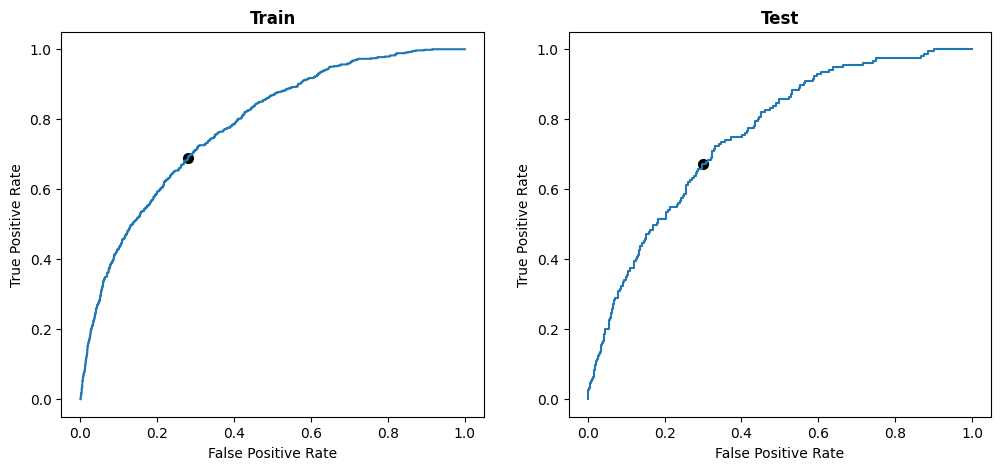

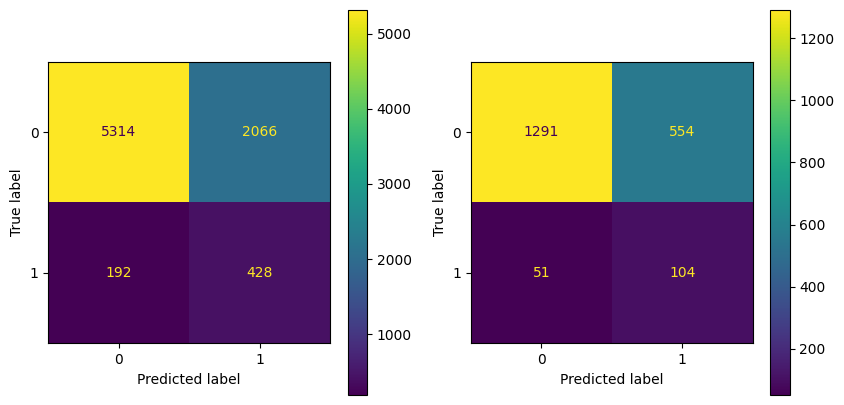

In [48]:
pipe_lr= best_threshold(X_train, X_test, y_train, y_test,  
                        features, 10, 
                        LogisticRegression(max_iter=500, class_weight='balanced', C=0.04), 0.5, 0.6)

   folds   fit_time  score_time  validation_score  train_score
0    0.0  72.070369    0.133812          0.745732     0.748085
1    1.0  68.022620    0.207603          0.745732     0.748005
2    2.0  65.829804    0.142117          0.748285     0.747939
3    3.0  48.010056    0.134607          0.741413     0.748544
4    4.0  56.191886    0.193814          0.740260     0.748697
5    5.0  57.419028    0.139915          0.746607     0.748240
6    6.0  54.421789    0.138626          0.745594     0.748331
7    7.0  56.719003    0.140657          0.751862     0.747374
8    8.0  55.049918    0.122511          0.746647     0.747876
9    9.0  47.316560    0.066037          0.740057     0.748682
10  mean  58.105103    0.141970          0.745219     0.748177

Best threshold:	0.5368421052631579

roc_auc train: 	0.7480624489937601 
roc_auc test: 	0.7483006262722265
Cost train : 	54.43100749984756
Cost test: 	54.46164352378784


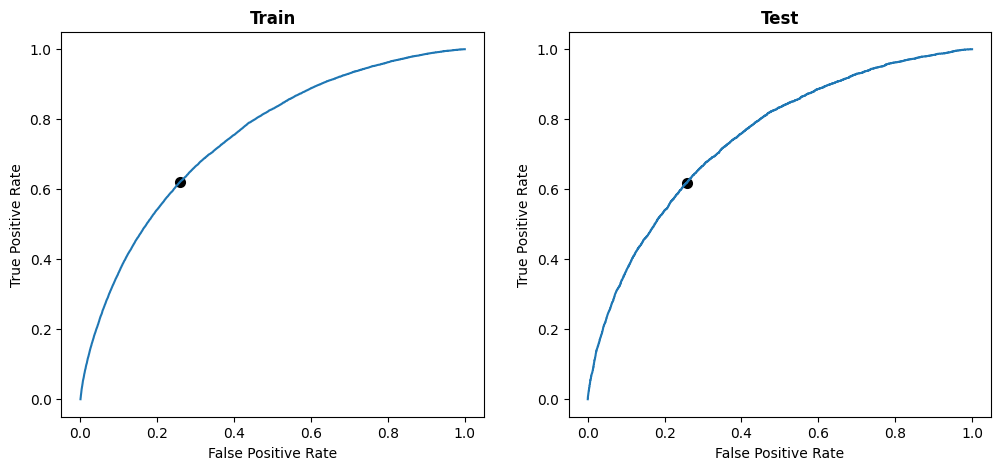

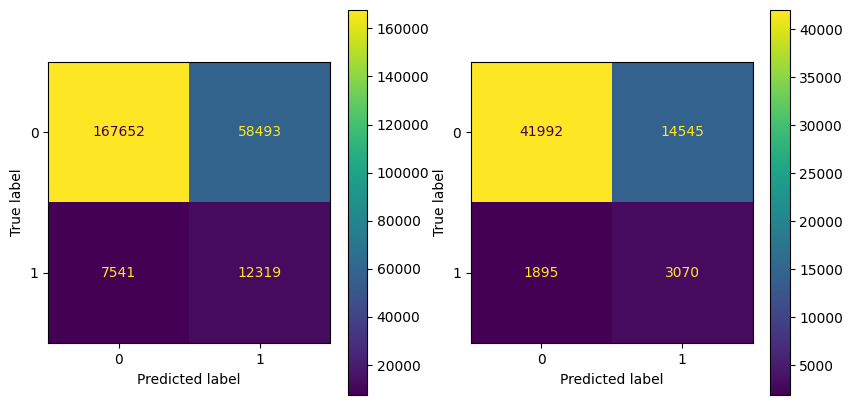

In [26]:
pipe_lr= best_threshold(X_train_full, X_test_full, y_train_full, y_test_full,  
                        features, 10, 
                        LogisticRegression(max_iter=500, class_weight='balanced', C=0.04), 0.5, 0.6)

In [ ]:
features_importance_from_coef(features, pipe_lr, 40)

## Best number of features
### Find best number of features

In [627]:
result_num_features = pd.DataFrame(num_features(X_train, y_train, 
                                                LogisticRegression(max_iter=500, C=0.04, class_weight='balanced'), 5))
result_num_features

Optimal number of features : 10


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.671032,0.015683,0.660468,0.696624,0.651344,0.679048,0.667677
1,0.723681,0.021457,0.749246,0.735365,0.685637,0.729746,0.718409
2,0.738208,0.021776,0.765457,0.744520,0.700307,0.748825,0.731931
3,0.739007,0.022566,0.764758,0.747148,0.697859,0.749612,0.735658
4,0.739134,0.024173,0.766654,0.745984,0.697979,0.756682,0.728369
...,...,...,...,...,...,...,...
249,0.739961,0.018829,0.735149,0.736111,0.725244,0.776598,0.726703
250,0.739960,0.018829,0.735144,0.736111,0.725244,0.776598,0.726703
251,0.739960,0.018829,0.735144,0.736111,0.725244,0.776598,0.726703
252,0.739961,0.018829,0.735149,0.736111,0.725244,0.776598,0.726703


 Best mean test score : 0.7480297665879886 for 10 features kept


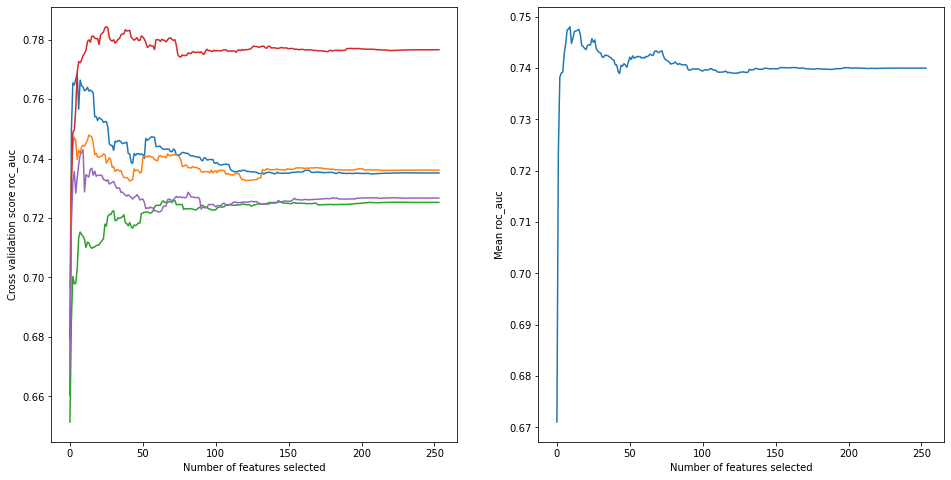

In [631]:
plot_num_features(result_num_features)

### Features selection

In [630]:
features_kept_logistic_70 = features_selection(X_train, y_train,
                                                LogisticRegression(max_iter=500, class_weight='balanced', C=0.04), 
                                                70)

In [632]:
features_kept_logistic_70

0            NAME_CONTRACT_TYPE
1                   CODE_GENDER
4                  CNT_CHILDREN
8               AMT_GOODS_PRICE
11                DAYS_EMPLOYED
                 ...           
239    WALLSMATERIAL_MODE_Mixed
247     EMERGENCYSTATE_MODE_Yes
249          DAYS_EMPLOYED_PERC
252         ANNUITY_INCOME_PERC
253                PAYMENT_RATE
Name: 0, Length: 70, dtype: object

In [248]:
features_kept_logistic_72.shape

(72,)

### Find best hypermarameters

In [634]:
fine_tune_model(X_train, y_train,  
                10, 
                LogisticRegression(max_iter=500, class_weight='balanced'), 
                features_kept_logistic_70, 
                {'clf__C': [0.09, 0.1, 0.11, 0.12]} )

Best parameters : {'clf__C': 0.11}


### train model

   folds  fit_time  score_time  validation_score  train_score
0    0.0  0.168118    0.009083          0.772620     0.782525
1    1.0  0.161271    0.007892          0.723053     0.786227
2    2.0  0.170934    0.009335          0.742110     0.784488
3    3.0  0.170555    0.007420          0.744624     0.785228
4    4.0  0.191519    0.008172          0.760206     0.783034
5    5.0  0.174430    0.009540          0.769626     0.782496
6    6.0  0.152790    0.007685          0.793972     0.779596
7    7.0  0.150851    0.007090          0.749060     0.784925
8    8.0  0.176368    0.008020          0.835781     0.775026
9    9.0  0.156774    0.009610          0.710202     0.787010
10  mean  0.167361    0.008385          0.760125     0.783056

Best threshold:	0.5157894736842106

roc_auc train: 	0.7819455371973074 
roc_auc test: 	0.7412151411836699
Cost train : 	50.55
Cost test: 	56.35


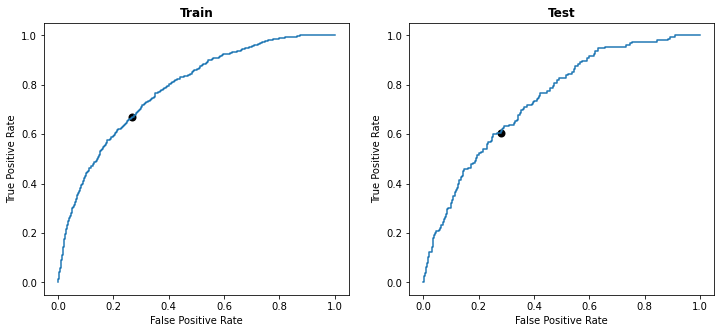

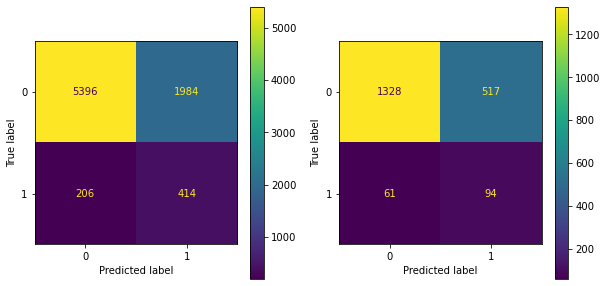

In [635]:
pipe_lr= best_threshold(X_train, X_test, y_train, y_test,  
                        features_kept_logistic_70, 10, 
                        LogisticRegression(max_iter=500, class_weight='balanced', C=0.11), 0.5, 0.6)

In [640]:
fine_tune_model(X_train_full, y_train_full, 
                10, 
                LogisticRegression(max_iter=500, class_weight='balanced'), 
                features_kept_logistic_70, 
                {'clf__C': [0.3, 0.4, 0.5]} )

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best parameters : {'clf__C': 0.4}


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


   folds   fit_time  score_time  validation_score  train_score
0    0.0  13.463791    0.078654          0.739595     0.740552
1    1.0  17.150952    0.081245          0.739354     0.740571
2    2.0  16.567179    0.102965          0.743152     0.740140
3    3.0  15.794423    0.082778          0.734755     0.741090
4    4.0  14.552900    0.072661          0.734377     0.741131
5    5.0  17.960836    0.071785          0.739434     0.740501
6    6.0  17.557471    0.068613          0.740429     0.740427
7    7.0  13.958804    0.084530          0.747166     0.739676
8    8.0  11.463552    0.068087          0.741653     0.740272
9    9.0   8.561559    0.041912          0.734328     0.741070
10  mean  14.703147    0.075323          0.739424     0.740543

Best threshold:	0.531578947368421

roc_auc train: 	0.7404874182066034 
roc_auc test: 	0.7405818549682577
Cost train : 	55.6561858498811
Cost test: 	55.24047998439075


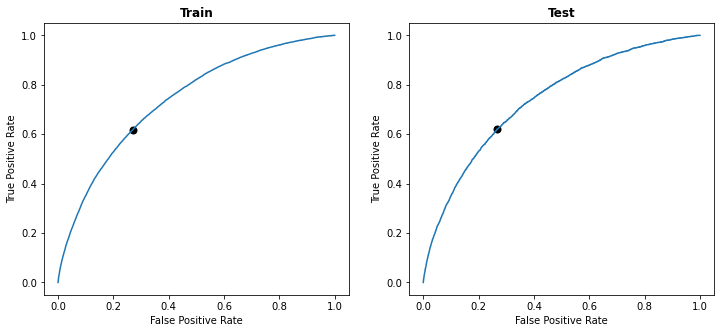

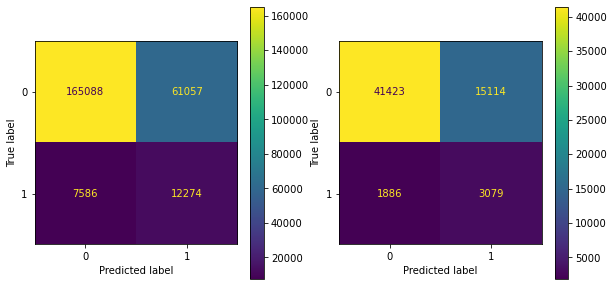

In [641]:
pipe_lr_full= best_threshold(X_train_full, X_test_full, y_train_full, y_test_full,  
                        features_kept_logistic_70, 10, 
                        LogisticRegression(max_iter=500, class_weight='balanced', C=0.4), 0.5, 0.6)

### Features importance

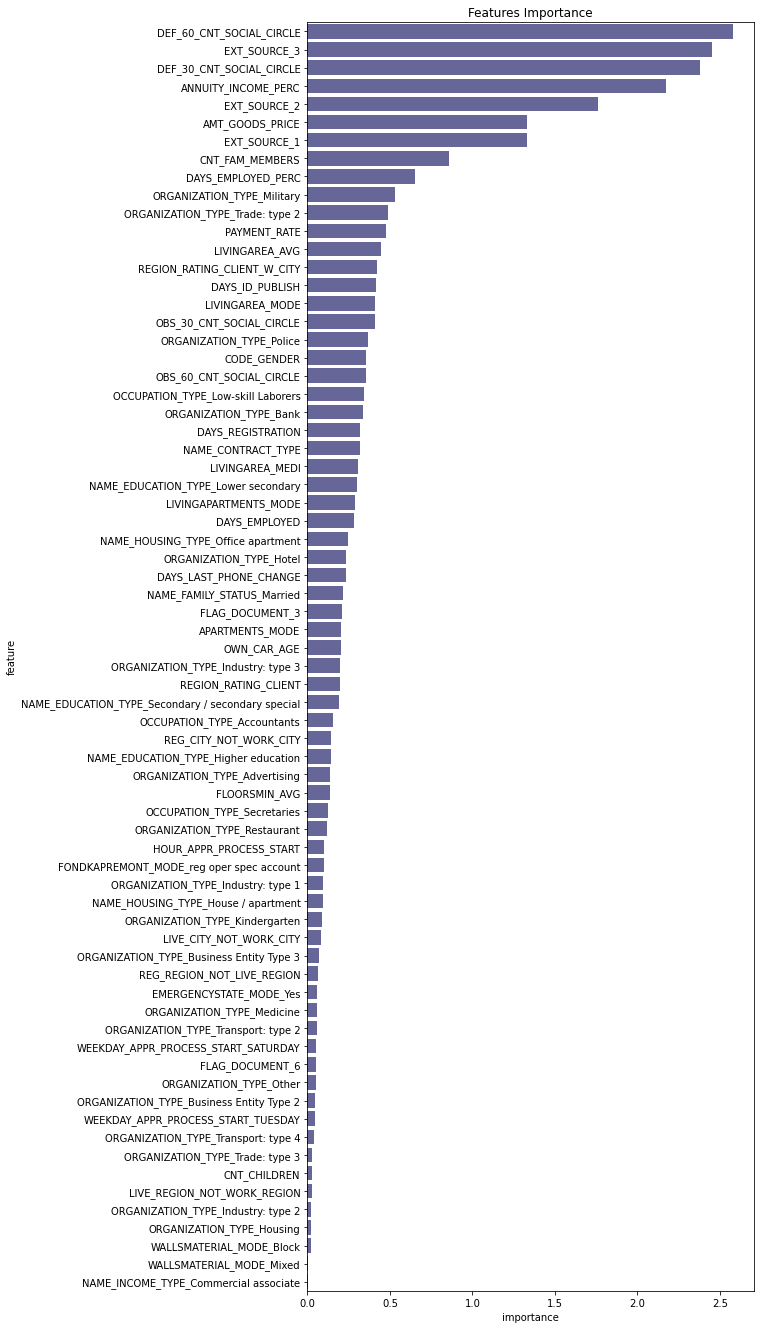

In [886]:
features_importance_from_coef(features_kept_logistic_70, pipe_lr_full, 70)

### Local features importance

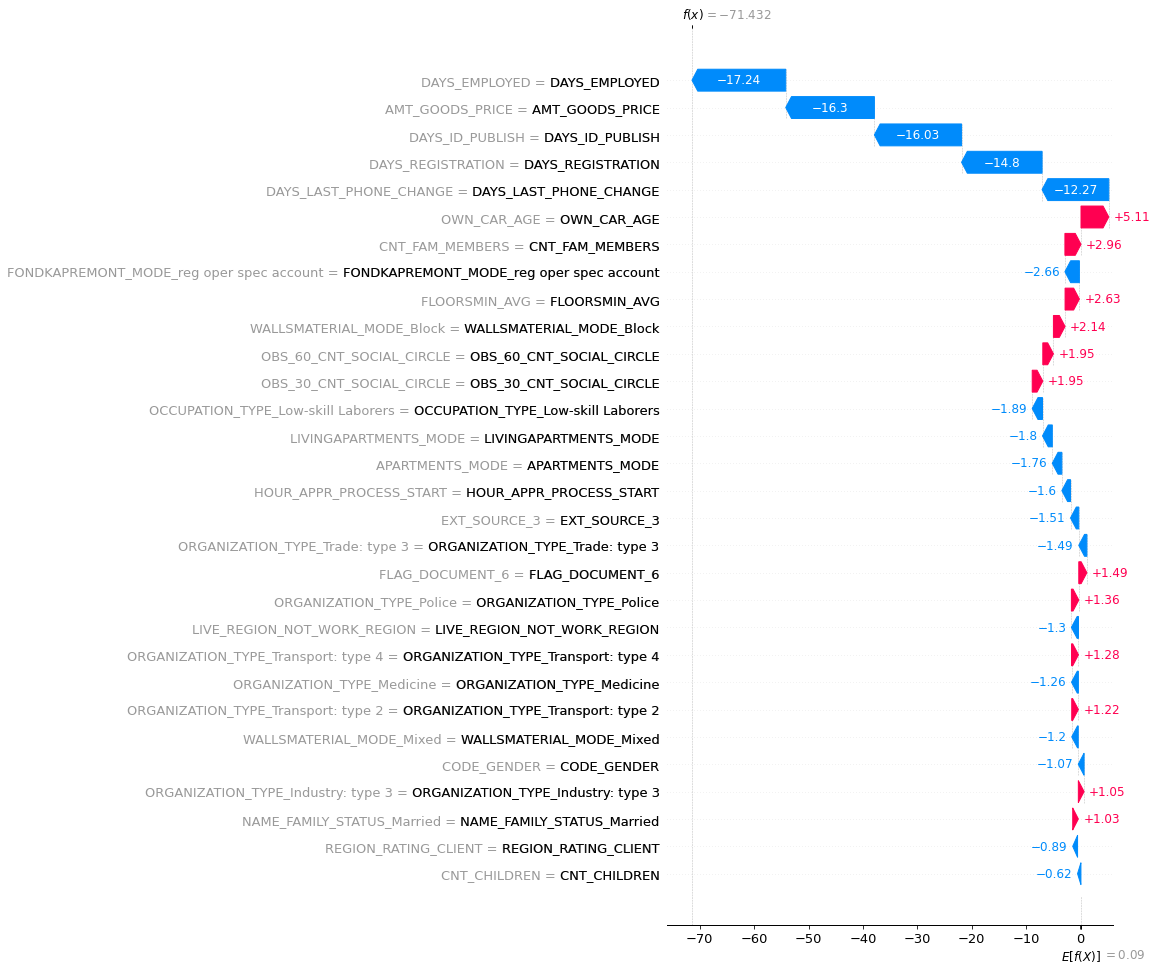

In [888]:
local_features(X_train[features_kept_logistic_70], X_test[features_kept_logistic_70], y_train, 10000, pipe_lr_full, 30)

## 10 Features 
### Features selection and train model

In [477]:
features_kept_logistic_10 = features_selection(X_train, y_train, 
                                                LogisticRegression(max_iter=500, class_weight='balanced', C=0.04), 
                                                10)


In [478]:
features_kept_logistic_10

7                             AMT_ANNUITY
8                         AMT_GOODS_PRICE
11                          DAYS_EMPLOYED
31                           EXT_SOURCE_1
32                           EXT_SOURCE_2
33                           EXT_SOURCE_3
78               DEF_30_CNT_SOCIAL_CIRCLE
99                       FLAG_DOCUMENT_19
182               ORGANIZATION_TYPE_Hotel
192    ORGANIZATION_TYPE_Industry: type 5
Name: 0, dtype: object

In [480]:
fine_tune_model(X_train, y_train, 
                10, 
                LogisticRegression(max_iter=500, class_weight='balanced'), 
                features_kept_logistic_10, 
                {'clf__C': [ 0.4, 0.5, 0.6, 0.7]} )

Best parameters : {'clf__C': 0.5}


   folds  fit_time  score_time  validation_score  train_score
0    0.0  0.124233    0.008340          0.773254     0.745990
1    1.0  0.182376    0.006477          0.700564     0.753858
2    2.0  0.124125    0.007014          0.754437     0.748108
3    3.0  0.115454    0.006000          0.730549     0.750708
4    4.0  0.065029    0.005951          0.746481     0.748916
5    5.0  0.062516    0.005079          0.753541     0.747439
6    6.0  0.063978    0.005419          0.771243     0.746245
7    7.0  0.054800    0.005887          0.726593     0.751310
8    8.0  0.068304    0.005841          0.774150     0.746080
9    9.0  0.053144    0.004942          0.723096     0.751525
10  mean  0.091396    0.006095          0.745391     0.749018

Best threshold:	0.631578947368421

roc_auc train: 	0.7489317248011189 
roc_auc test: 	0.7528944837835475
Cost train : 	51.65
Cost test: 	54.1


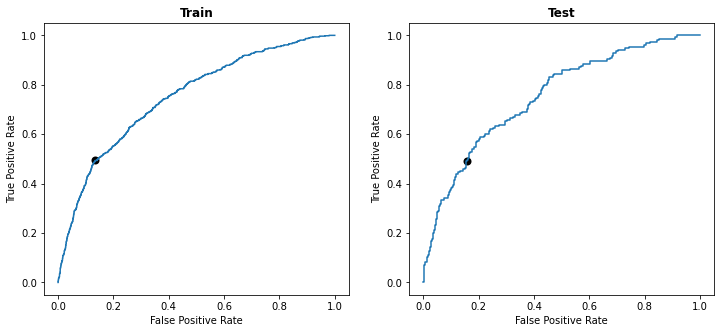

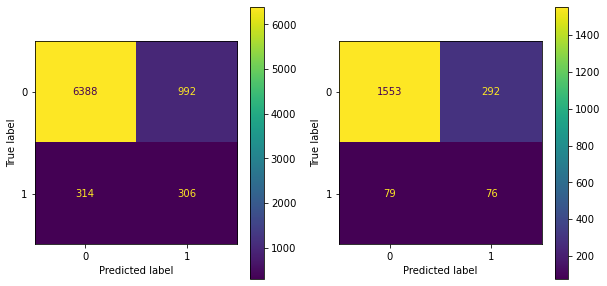

In [481]:
pipe_lr_10 = best_threshold(X_train, X_test, y_train, y_test, 
                            features_kept_logistic_10, 
                            10, 
                            LogisticRegression(max_iter=500, class_weight='balanced', C=0.5), 
                            0.5, 1)

### Features importance

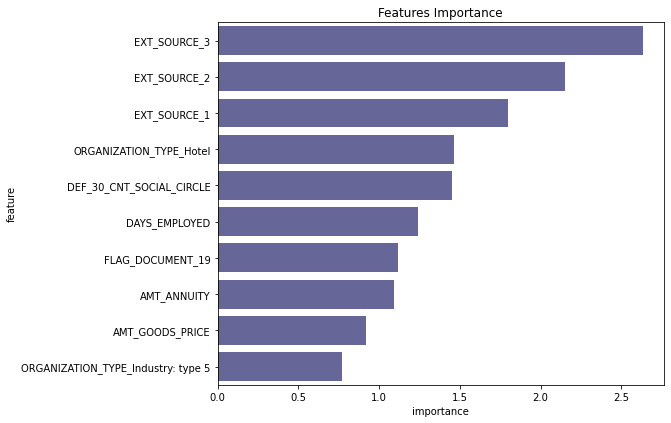

In [488]:
features_importance_from_coef(features_kept_logistic_10, pipe_lr_10, 20)

### Local features importance

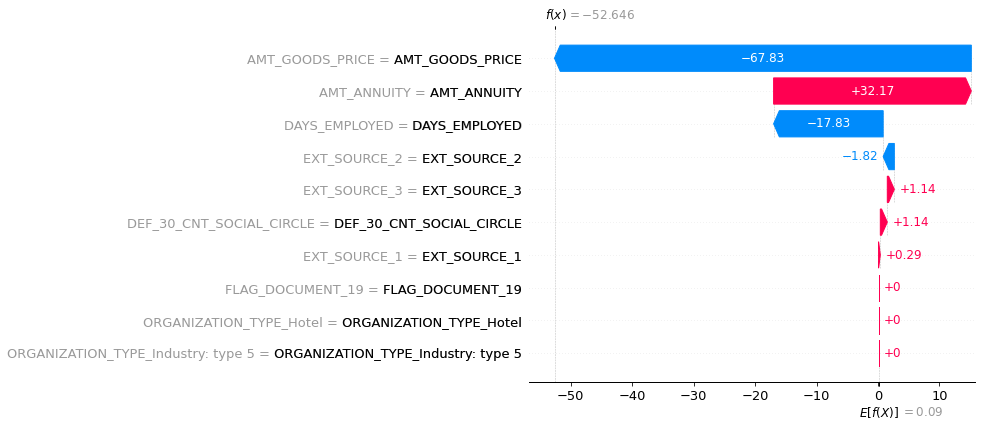

In [489]:
local_features(X_train_10, X_test_10, y_train_10, 10000, pipe_lr_10, 10)

# Decision Tree 
## With all features

In [838]:
X_train, X_test, y_train, y_test = train_test(data_transformed, 0.2)
features = X_train.columns

### Bayesian optimisation

In [851]:
def bo_params_rf(max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, min_impurity_decrease):
    
    params = {
        'max_depth': max_depth,
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'min_weight_fraction_leaf': int(min_weight_fraction_leaf), 
        'min_impurity_decrease' : min_impurity_decrease}
    
    clf = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            min_weight_fraction_leaf=params['min_weight_fraction_leaf'],
            min_impurity_decrease=params['min_impurity_decrease'], 
        class_weight = 'balanced')
    score = clf_result(clf,  X_train, y_train, 5)
    return score

In [860]:
import bayes_opt
from bayes_opt import BayesianOptimization
rf_bo = BayesianOptimization(bo_params_rf, {
        'max_depth': [5, 30],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [100, 500],
        'min_weight_fraction_leaf': [0, 0.5], 
        'min_impurity_decrease' : [0, 1]})

In [861]:
results = rf_bo.maximize(n_iter=60, init_points=10, acq='ei')

|   iter    |  target   | max_depth | min_im... | min_sa... | min_sa... | min_we... |
-------------------------------------------------------------------------------------



Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument



| 1         | 0.5       | 14.77     | 0.1432    | 431.3     | 4.721     | 0.3019    |
| 2         | 0.652     | 10.76     | 0.01466   | 439.8     | 2.869     | 0.1559    |
| 3         | 0.5       | 23.97     | 0.1091    | 397.7     | 3.75      | 0.1982    |
| 4         | 0.5       | 13.09     | 0.8349    | 418.4     | 4.004     | 0.1507    |
| 5         | 0.5       | 22.98     | 0.811     | 118.4     | 9.64      | 0.2181    |
| 6         | 0.5       | 11.68     | 0.3335    | 222.1     | 8.863     | 0.131     |
| 7         | 0.5       | 19.06     | 0.4761    | 496.7     | 8.232     | 0.4489    |
| 8         | 0.5       | 15.06     | 0.3652    | 357.2     | 9.346     | 0.4837    |
| 9         | 0.5       | 13.98     | 0.6515    | 215.4     | 5.855     | 0.1065    |
| 10        | 0.5       | 10.62     | 0.7608    | 297.7     | 2.697     | 0.03667   |
| 11        | 0.5       | 11.04     | 0.8553    | 440.0     | 3.699     | 0.4056    |
| 12        | 0.5       | 9.63      | 0.424     | 353.

In [872]:
decision_tree = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=11, 
                                       min_samples_split=3, 
                                       min_samples_leaf=440,
                                       max_features=None, 
                                       random_state=42, 
                                        class_weight='balanced')

   folds  fit_time  score_time  validation_score  train_score
0    0.0  0.205891    0.009217          0.741717     0.739170
1    1.0  0.195357    0.008830          0.614990     0.750671
2    2.0  0.173824    0.009274          0.715032     0.741519
3    3.0  0.193201    0.014623          0.669169     0.745551
4    4.0  0.191010    0.008706          0.663224     0.741505
5    5.0  0.172387    0.008740          0.683375     0.741334
6    6.0  0.183588    0.008826          0.757660     0.742590
7    7.0  0.191786    0.010174          0.653412     0.744192
8    8.0  0.172208    0.008787          0.711022     0.738644
9    9.0  0.196234    0.008600          0.656548     0.746779
10  mean  0.187549    0.009578          0.686615     0.743195

Best threshold:	0.5157894736842106

roc_auc train: 	0.7425366072209109 
roc_auc test: 	0.6822939068100359
Cost train : 	55.25
Cost test: 	61.8


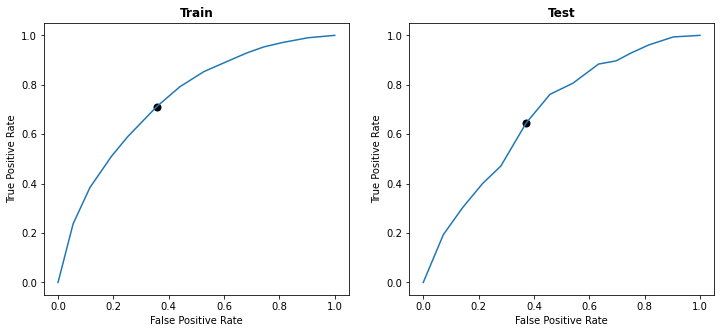

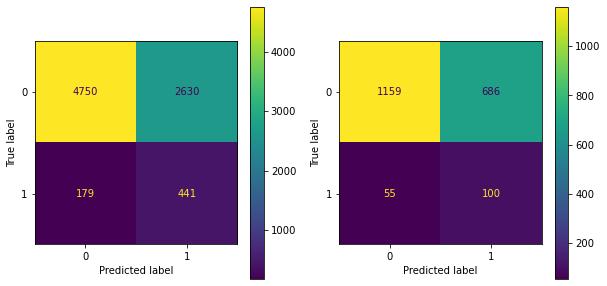

In [873]:
pipe_tree= best_threshold(X_train, X_test, y_train, y_test,  
                        features, 10, 
                        decision_tree, 0.4, 0.6)


## Best number of features
### Find best number of features

In [874]:
result_num_features = pd.DataFrame(num_features(X_train, y_train, decision_tree, 5))
result_num_features

Optimal number of features : 2


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.673508,0.018799,0.675253,0.688175,0.640462,0.694444,0.669205
1,0.711786,0.024072,0.740837,0.727601,0.670830,0.717515,0.702148
2,0.704668,0.019667,0.729328,0.721938,0.676179,0.705875,0.690019
3,0.696190,0.014126,0.711718,0.697272,0.673078,0.709442,0.689437
4,0.699406,0.014614,0.709989,0.711524,0.674401,0.710074,0.691041
...,...,...,...,...,...,...,...
249,0.694843,0.012772,0.699422,0.703126,0.672303,0.708932,0.690434
250,0.694843,0.012772,0.699422,0.703126,0.672303,0.708932,0.690434
251,0.694843,0.012772,0.699422,0.703126,0.672303,0.708932,0.690434
252,0.694843,0.012772,0.699422,0.703126,0.672303,0.708932,0.690434


 Best mean test score : 0.7117864323804528 for 2 features kept


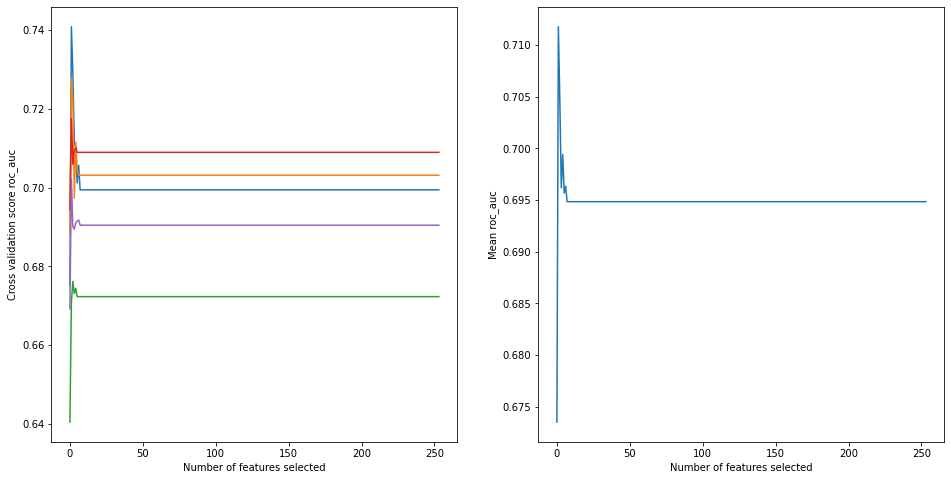

In [875]:
plot_num_features(result_num_features)

### Features selection and train model

In [876]:
features_kept_tree_2 = features_selection(X_train, y_train, 
                                          decision_tree, 2)

In [877]:
features_kept_tree_2

32    EXT_SOURCE_2
33    EXT_SOURCE_3
Name: 0, dtype: object

   folds  fit_time  score_time  validation_score  train_score
0    0.0  0.014176    0.005075          0.753355     0.726851
1    1.0  0.014462    0.006219          0.649991     0.739754
2    2.0  0.016220    0.003222          0.737237     0.728178
3    3.0  0.015730    0.003888          0.697788     0.732453
4    4.0  0.015064    0.003184          0.706181     0.729850
5    5.0  0.011826    0.003200          0.700968     0.734595
6    6.0  0.011963    0.003223          0.726571     0.732761
7    7.0  0.012577    0.003818          0.675616     0.737101
8    8.0  0.012495    0.003863          0.724965     0.731584
9    9.0  0.014615    0.003239          0.664306     0.736506
10  mean  0.013913    0.003893          0.703698     0.732963

Best threshold:	0.5105263157894737

roc_auc train: 	0.735132769472856 
roc_auc test: 	0.710607570591835
Cost train : 	56.637499999999996
Cost test: 	60.550000000000004


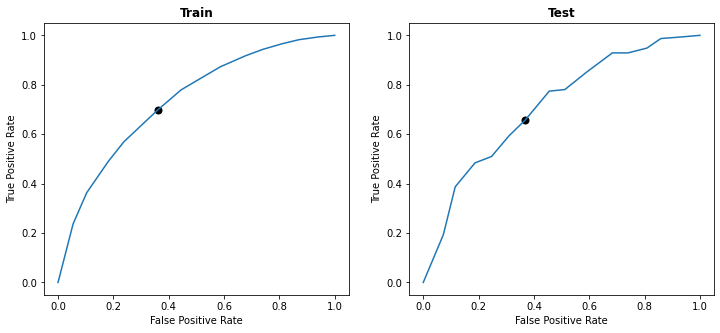

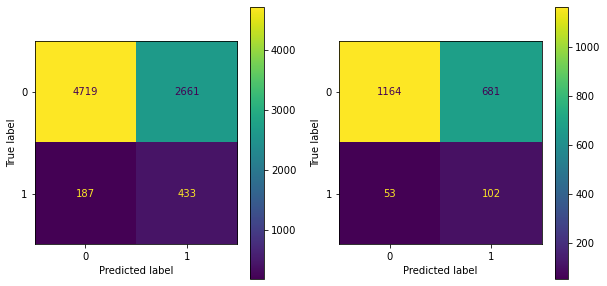

In [878]:
pipe_tree_2= best_threshold(X_train, X_test, y_train, y_test,  
                        features_kept_tree_2, 10, 
                        decision_tree, 0.5, 0.6)

### Features importance

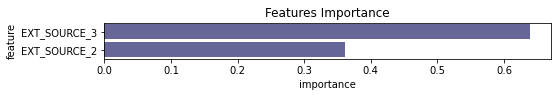

In [883]:
features_importance(features_kept_tree_2, pipe_tree_2, 2)

### Local features importance

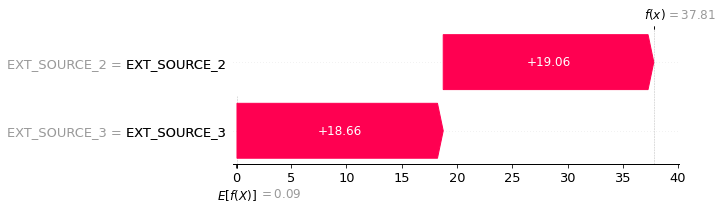

In [892]:
local_features(X_train[features_kept_tree_2], X_test[features_kept_tree_2], y_train, 100, pipe_tree_2, 2)

## More Features 
### Selection of 10 features

In [893]:
features_kept_tree_10 = features_selection(X_train, y_train, 
                                          decision_tree, 10)

   folds  fit_time  score_time  validation_score  train_score
0    0.0  0.033922    0.004879          0.735226     0.736579
1    1.0  0.031890    0.005063          0.617329     0.751843
2    2.0  0.028855    0.003658          0.712814     0.737930
3    3.0  0.028611    0.003949          0.699733     0.741687
4    4.0  0.031530    0.003656          0.688369     0.738306
5    5.0  0.026925    0.003701          0.709787     0.738370
6    6.0  0.029406    0.003664          0.757988     0.742488
7    7.0  0.030182    0.005257          0.674797     0.742478
8    8.0  0.040233    0.003719          0.729314     0.737634
9    9.0  0.039024    0.003902          0.687210     0.742954
10  mean  0.032058    0.004145          0.701257     0.741027

Best threshold:	0.5

roc_auc train: 	0.7425366072209109 
roc_auc test: 	0.6822939068100359
Cost train : 	55.25
Cost test: 	61.8


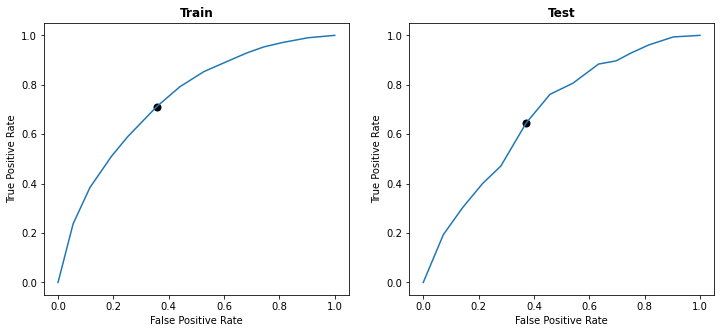

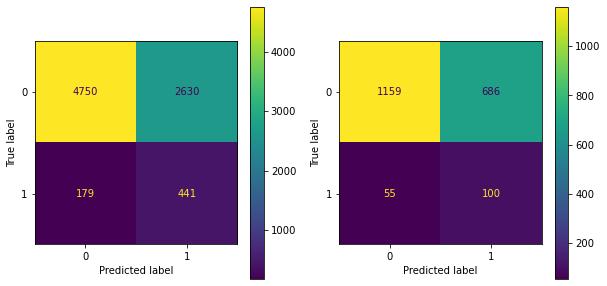

In [894]:
pipe_tree_10= best_threshold(X_train, X_test, y_train, y_test,  
                        features_kept_tree_10, 10, 
                        decision_tree, 0.5, 0.6)

[Text(0.47058823529411764, 0.9285714285714286, 'EXT_SOURCE_3 <= 0.595\nsamples = 8000\nvalue = [4000.0, 4000.0]'),
 Text(0.23529411764705882, 0.7857142857142857, 'EXT_SOURCE_2 <= 0.588\nsamples = 4724\nvalue = [2286.721, 3258.065]'),
 Text(0.11764705882352941, 0.6428571428571429, 'EXT_SOURCE_3 <= 0.375\nsamples = 1932\nvalue = [877.507, 2019.355]'),
 Text(0.058823529411764705, 0.5, 'samples = 549\nvalue = [217.886, 948.387]'),
 Text(0.17647058823529413, 0.5, 'DAYS_REGISTRATION <= 0.85\nsamples = 1383\nvalue = [659.621, 1070.968]'),
 Text(0.11764705882352941, 0.35714285714285715, 'samples = 844\nvalue = [416.802, 483.871]'),
 Text(0.23529411764705882, 0.35714285714285715, 'samples = 539\nvalue = [242.818, 587.097]'),
 Text(0.35294117647058826, 0.6428571428571429, 'EXT_SOURCE_3 <= 0.35\nsamples = 2792\nvalue = [1409.214, 1238.71]'),
 Text(0.29411764705882354, 0.5, 'samples = 658\nvalue = [313.821, 509.677]'),
 Text(0.4117647058823529, 0.5, 'EXT_SOURCE_1 <= 0.535\nsamples = 2134\nvalue = 

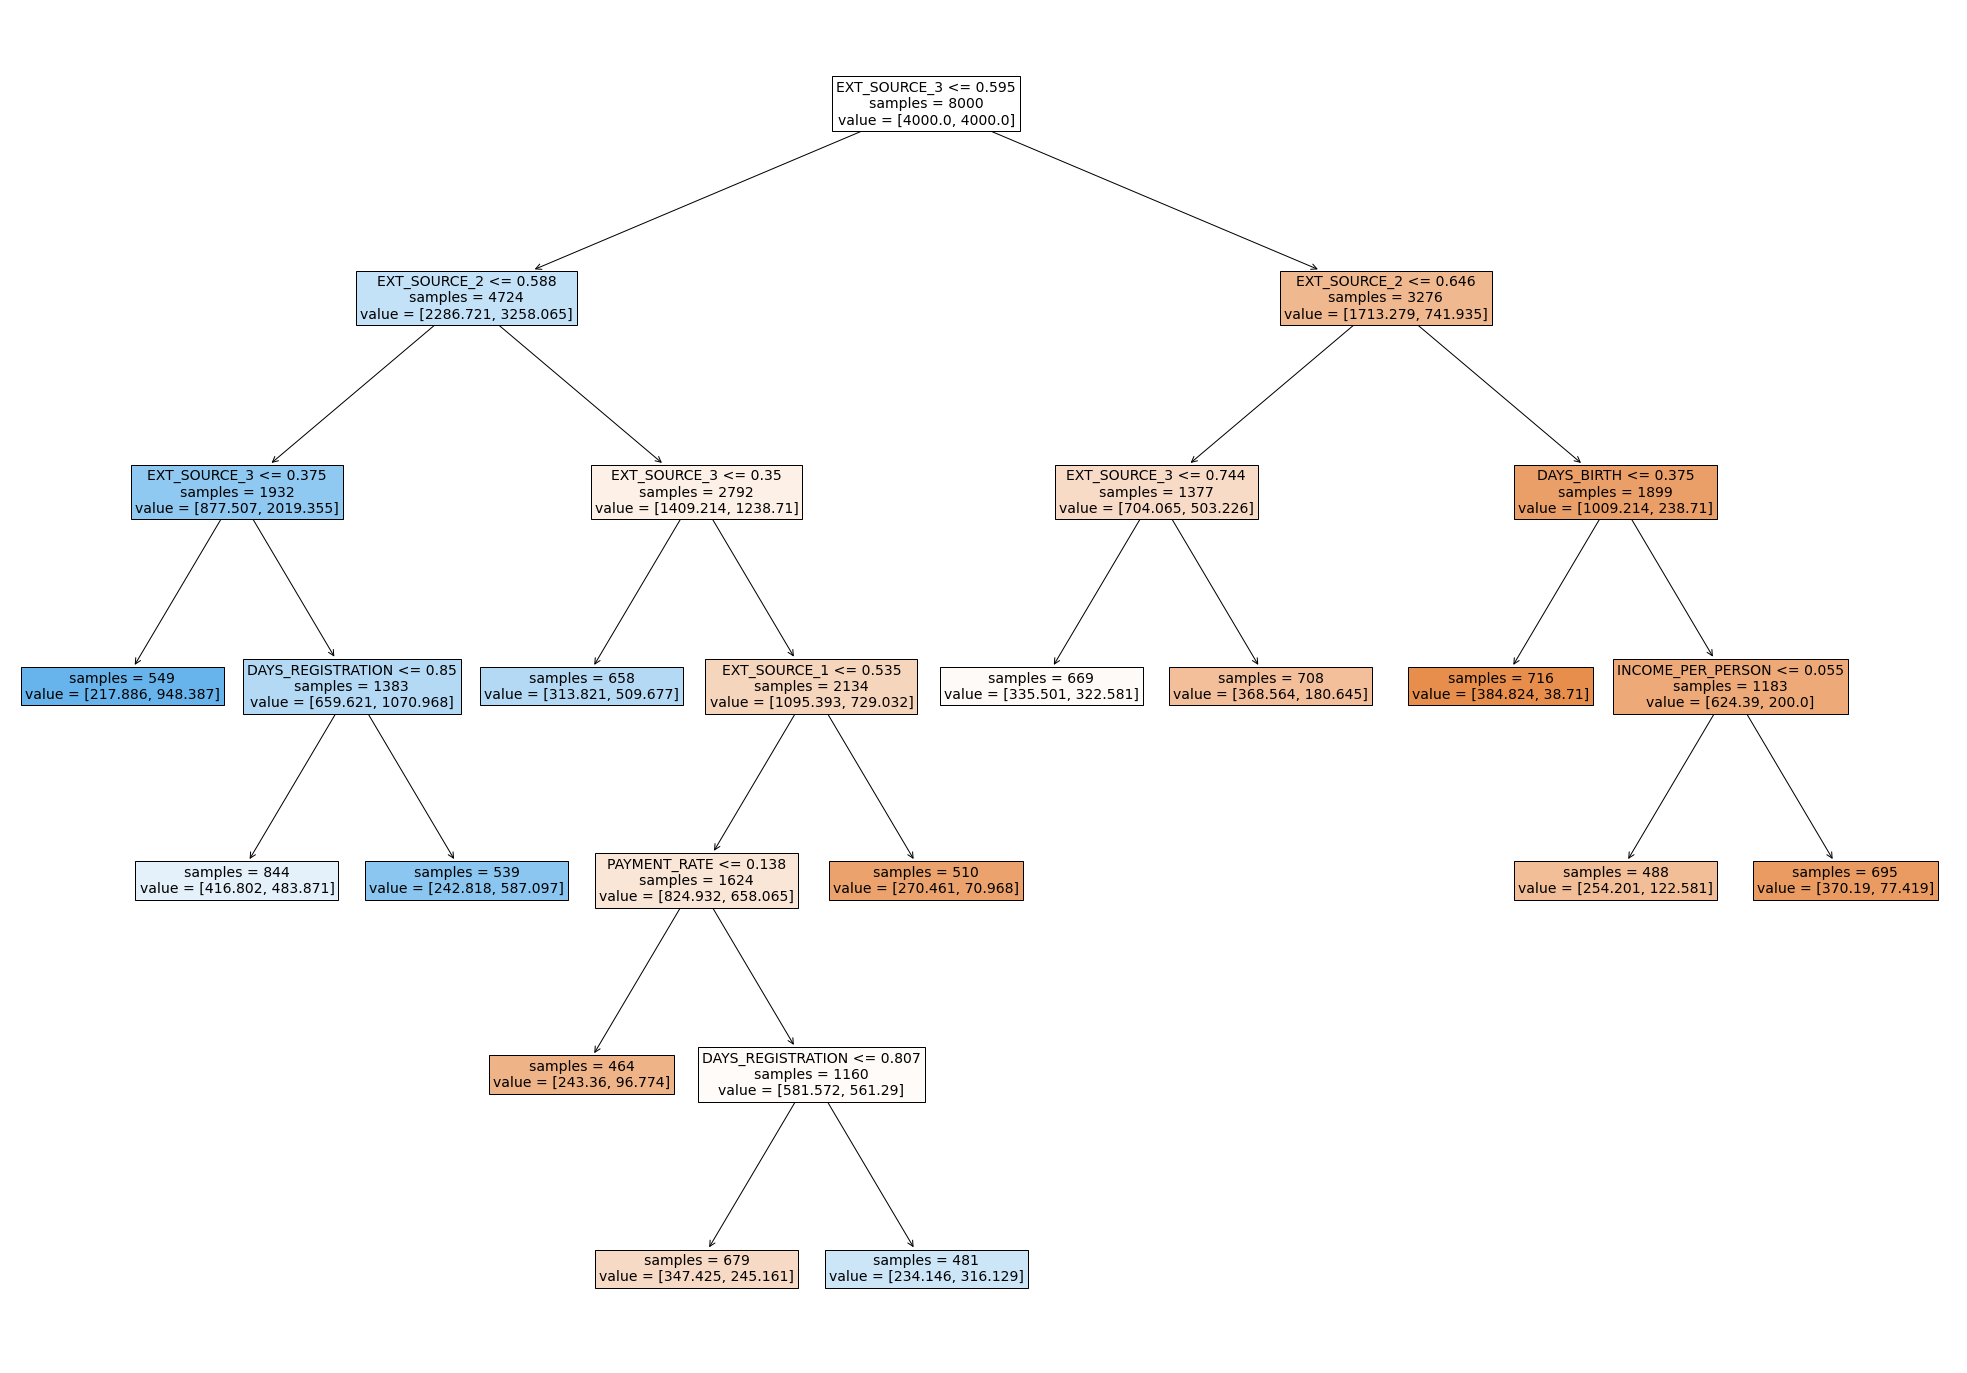

In [903]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(35, 25))
plot_tree(ax=ax, decision_tree=pipe_tree_10['clf'], max_depth=6, feature_names=list(features_kept_tree_10), filled=True, fontsize=14, impurity=False, node_ids=False, proportion=False, rounded=False, precision=3)

### Features importance

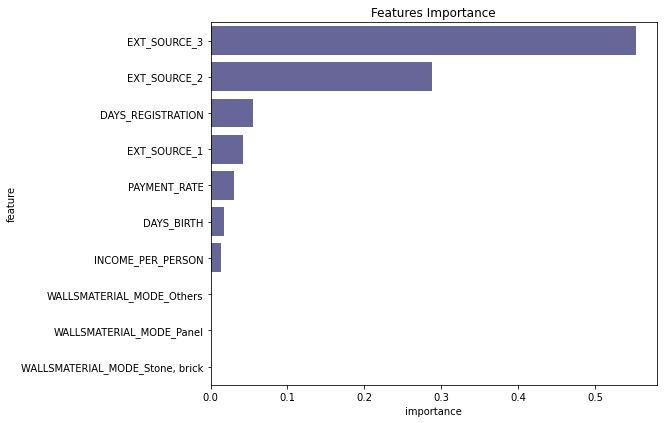

In [904]:
features_importance(features_kept_tree_10, pipe_tree_10, 20)

### Local features importance

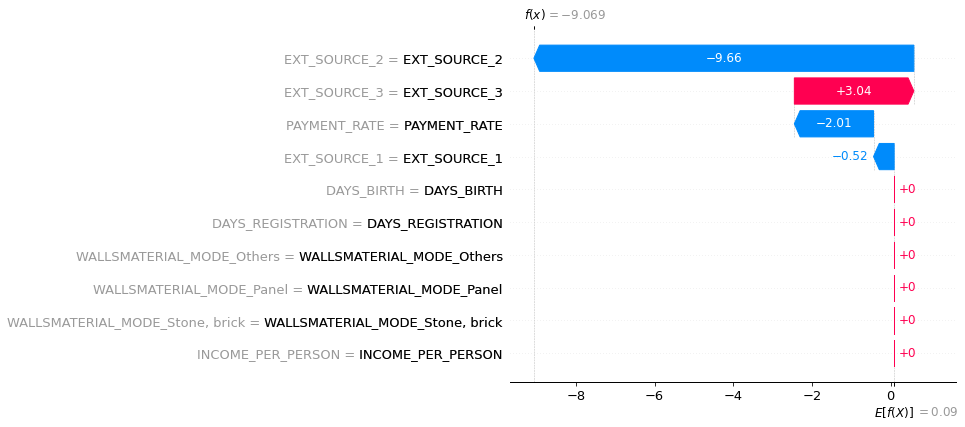

In [909]:
local_features(X_train[features_kept_tree_10], X_test[features_kept_tree_10], y_train, 100, pipe_tree_10, 10)

## Calibrated - 20 features

   folds  fit_time  score_time  validation_score  train_score
0    0.0  0.070513    0.006797          0.762184     0.743594
1    1.0  0.070114    0.007647          0.636900     0.756860
2    2.0  0.102583    0.006374          0.738209     0.745225
3    3.0  0.095355    0.007364          0.724932     0.752415
4    4.0  0.081616    0.005710          0.697286     0.743821
5    5.0  0.062587    0.005561          0.727183     0.747257
6    6.0  0.075096    0.005198          0.727249     0.750297
7    7.0  0.062202    0.005286          0.698947     0.748368
8    8.0  0.063479    0.005513          0.739357     0.748854
9    9.0  0.061151    0.005441          0.696794     0.751282
10  mean  0.074470    0.006089          0.714904     0.748797

Best threshold:	0.1

roc_auc test: 	0.7508028455284553 
roc_auc test: 	0.7151289448378355
Cost train : 	53.025
Cost test: 	57.35


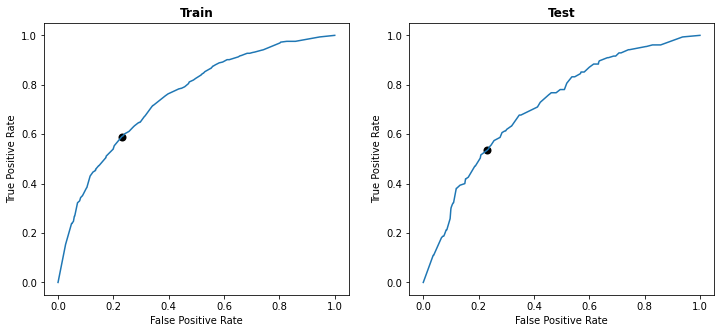

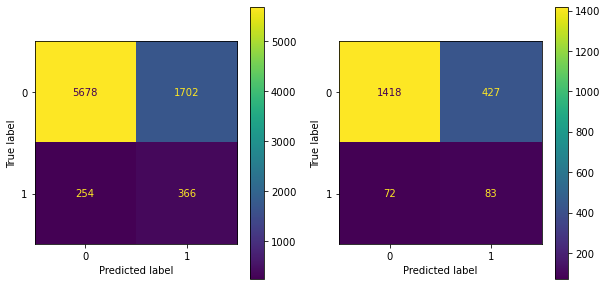

In [917]:
from sklearn.calibration import CalibratedClassifierCV
decision_tree = DecisionTreeClassifier(criterion='gini', 
                       splitter='best', 
                       max_depth=5, 
                       min_samples_split=2, 
                       min_samples_leaf=300, 
                       min_weight_fraction_leaf=0.0, 
                       max_features=None, 
                       random_state=42, 
                       max_leaf_nodes=None, 
                       min_impurity_decrease=0.0,  
                       class_weight='balanced')

pipe_trained_uncalib, pipe_trained_calib= best_threshold_with_calibration(X_train, X_test, y_train, y_test, 
                                                                          features_kept_tree_10, 10, 
                                                                          decision_tree, 0.1, 0.6)

   folds  fit_time  score_time  validation_score  train_score
0    0.0  3.513820    0.041709          0.715532     0.721500
1    1.0  3.506344    0.042768          0.718499     0.720407
2    2.0  3.302735    0.032906          0.717297     0.719727
3    3.0  3.253199    0.033254          0.712593     0.721496
4    4.0  3.783608    0.045840          0.713386     0.720473
5    5.0  3.784818    0.040311          0.715642     0.721296
6    6.0  3.112566    0.031391          0.712065     0.720988
7    7.0  3.098950    0.032531          0.720204     0.720760
8    8.0  2.720168    0.035324          0.714899     0.720142
9    9.0  2.710121    0.036114          0.710429     0.720482
10  mean  3.278633    0.037215          0.715055     0.720727

Best threshold:	0.1

roc_auc test: 	0.7207539706687219 
roc_auc test: 	0.7179255585034181
Cost train : 	58.07320989410785
Cost test: 	57.80137231309551


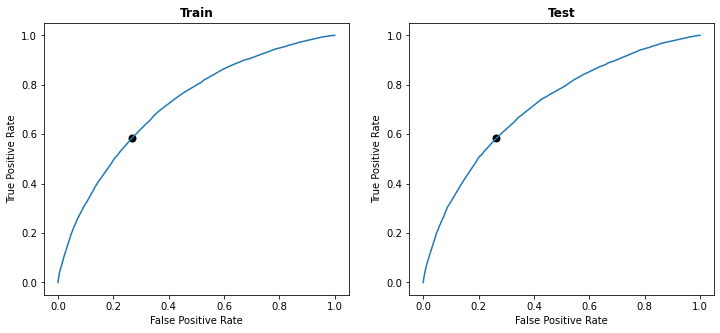

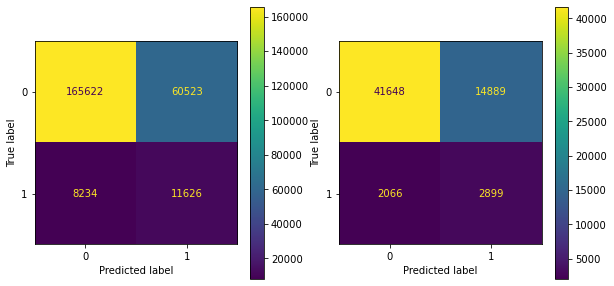

In [919]:
pipe_trained_uncalib_full, pipe_trained_calib_full= best_threshold_with_calibration(X_train_full, X_test_full, y_train_full, y_test_full, 
                                                                          features_kept_tree_10, 10, 
                                                                          decision_tree, 0.1, 0.6)

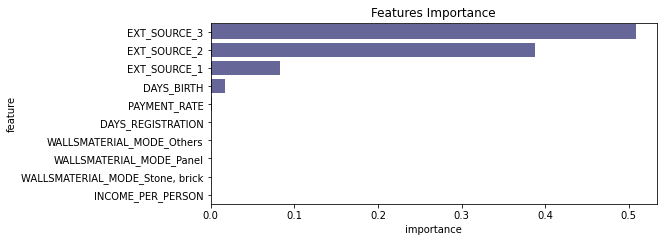

In [920]:
features_importance(features_kept_tree_10, pipe_trained_uncalib_full, 10)

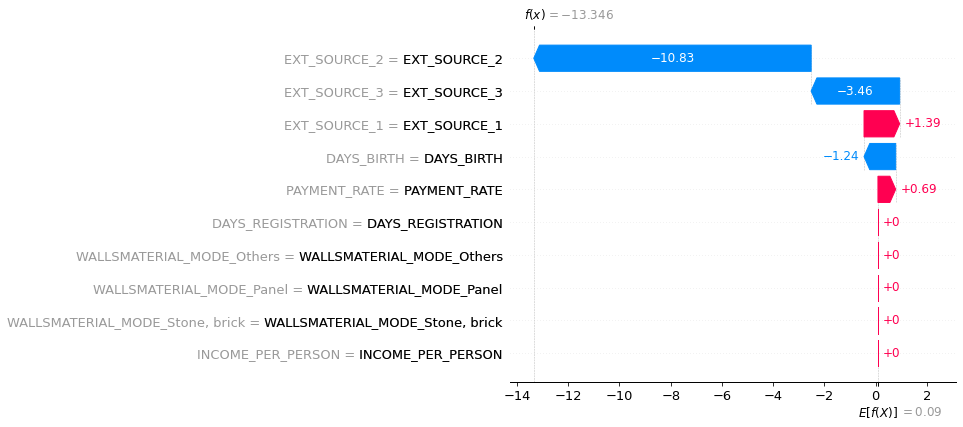

In [922]:
local_features(X_train[features_kept_tree_10], X_test[features_kept_tree_10], y_train, 100, pipe_trained_uncalib_full, 10)

[Text(0.5, 0.9, 'EXT_SOURCE_3 <= 0.596\nsamples = 246005\nvalue = [123002.5, 123002.5]'),
 Text(0.25, 0.7, 'EXT_SOURCE_2 <= 0.529\nsamples = 147119\nvalue = [71486.076, 97169.498]'),
 Text(0.125, 0.5, 'EXT_SOURCE_3 <= 0.346\nsamples = 50067\nvalue = [22719.116, 51387.298]'),
 Text(0.0625, 0.3, 'EXT_SOURCE_2 <= 0.241\nsamples = 13047\nvalue = [5384.164, 19497.073]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'EXT_SOURCE_2 <= 0.192\nsamples = 37020\nvalue = [17334.952, 31890.225]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'EXT_SOURCE_3 <= 0.353\nsamples = 97052\nvalue = [48766.96, 45782.199]'),
 Text(0.3125, 0.3, 'EXT_SOURCE_3 <= 0.162\nsamples = 22883\nvalue = [10868.407, 17967.284]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'EXT_SOURCE_2 <= 0.782\nsamples = 74169\nvalue = [37898.553, 27814.916]'),
 Text(0.40625, 0.1, '\n  (...

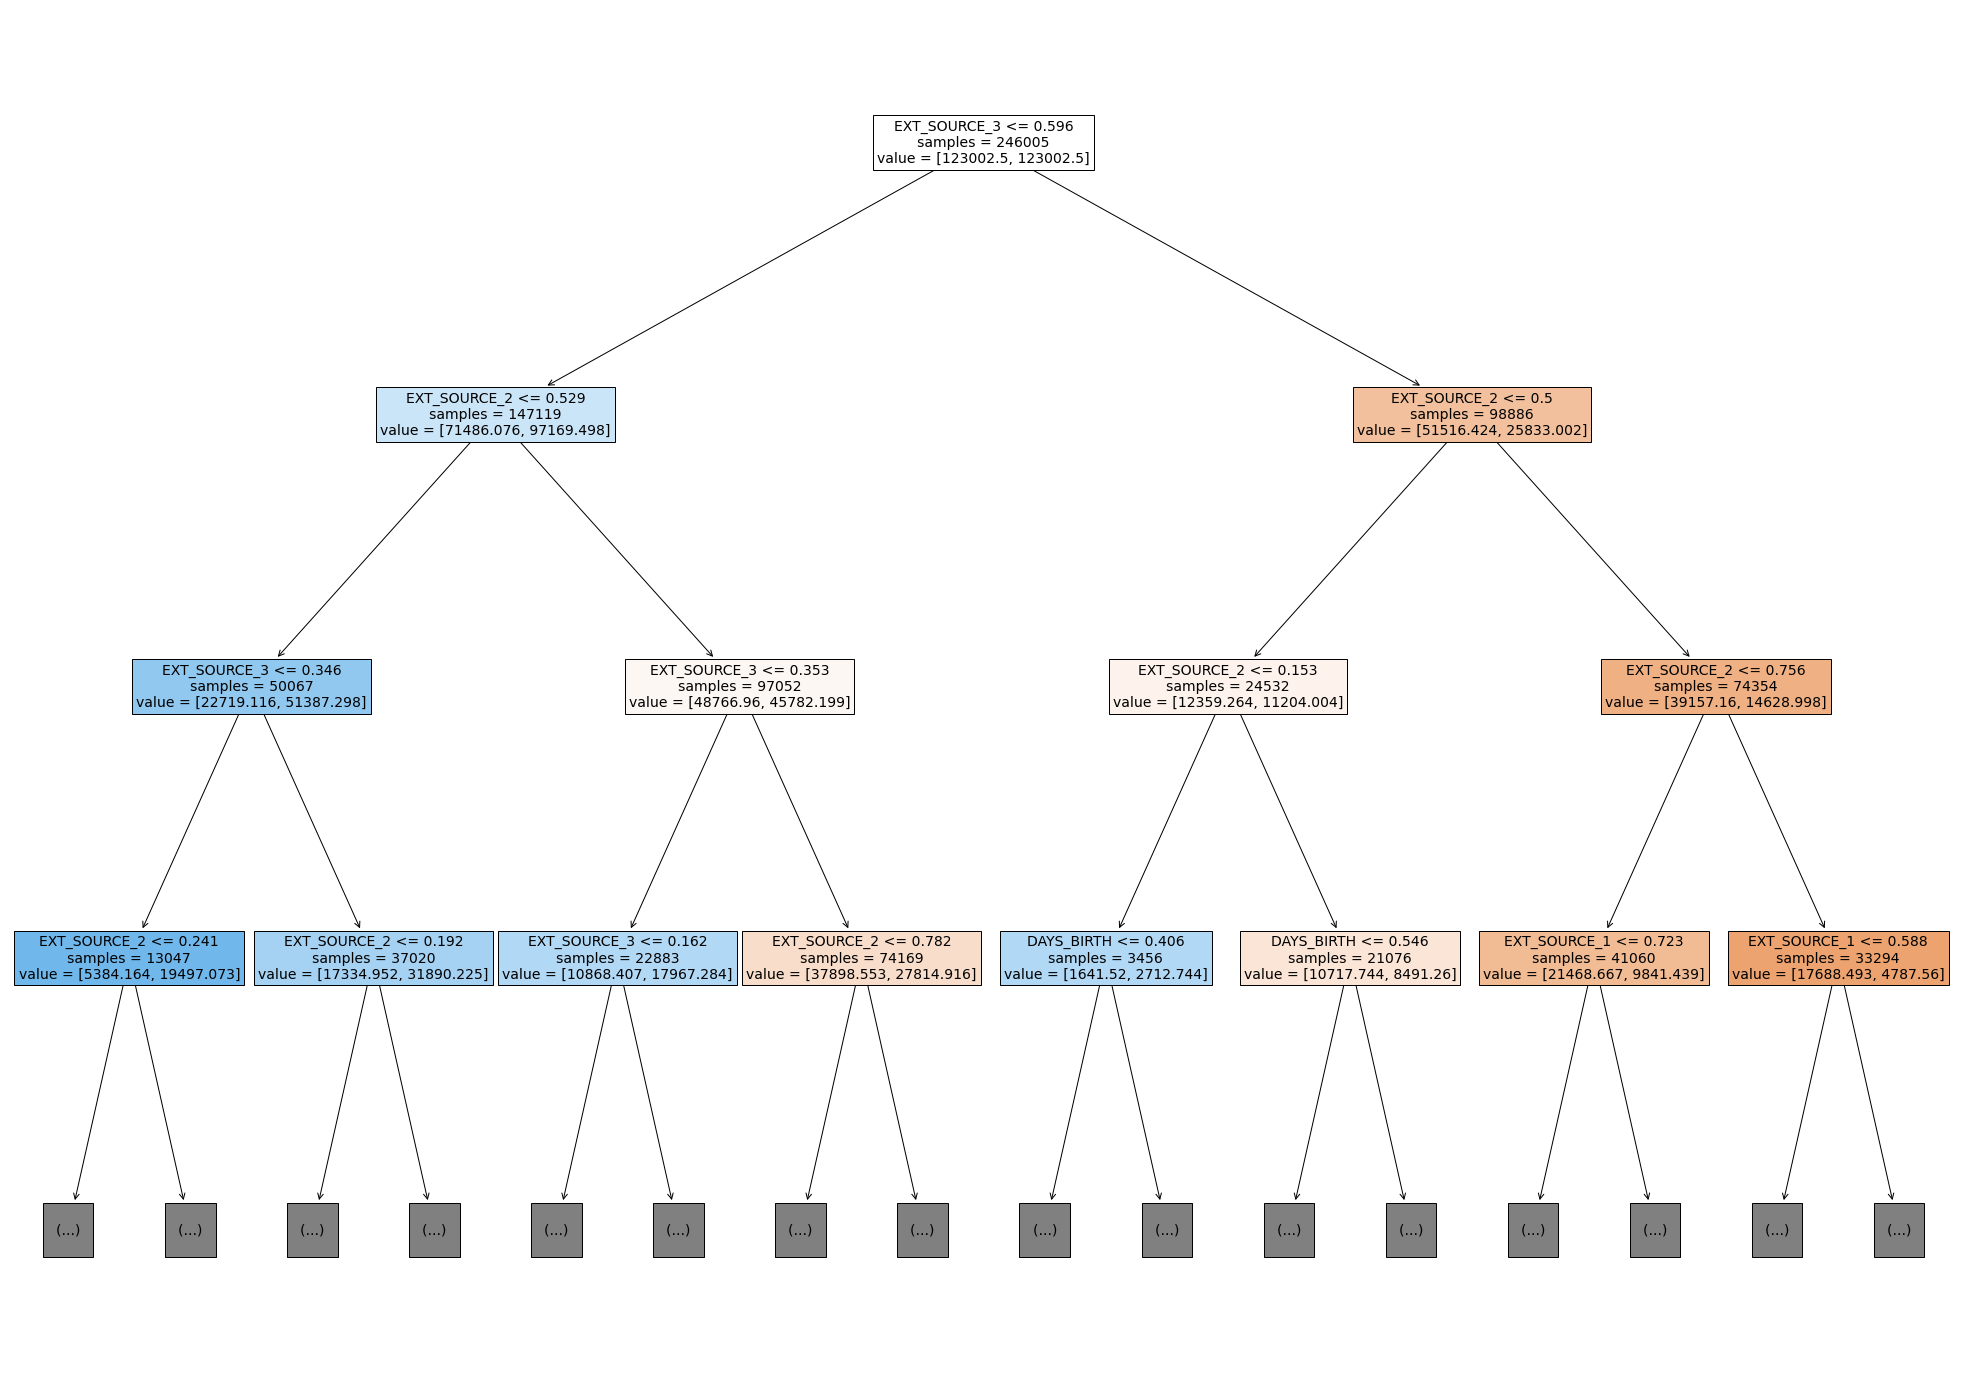

In [933]:
fig, ax = plt.subplots(figsize=(35, 25))
plot_tree(ax=ax, decision_tree=pipe_trained_uncalib_full['clf'], max_depth=3, feature_names=list(features_kept_tree_10), filled=True, fontsize=14, impurity=False, node_ids=False, proportion=False, rounded=False, precision=3)

# lightgbm - balanced
## With all features

In [970]:
features = X_train.columns

In [971]:
lgbm_class = LGBMClassifier(
            n_estimators=150,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            class_weight='balanced')

   folds  fit_time  score_time  validation_score  train_score
0    0.0  1.412197    0.022580          0.790476     0.917525
1    1.0  1.638214    0.028713          0.677135     0.917020
2    2.0  1.416997    0.024208          0.774215     0.917354
3    3.0  1.483900    0.023666          0.750590     0.915763
4    4.0  1.374622    0.023443          0.746132     0.918485
5    5.0  1.513942    0.024136          0.767921     0.916115
6    6.0  1.465371    0.022549          0.778368     0.912223
7    7.0  1.510034    0.023231          0.741673     0.919800
8    8.0  1.485172    0.026361          0.771287     0.920943
9    9.0  1.431742    0.019894          0.727948     0.917533
10  mean  1.473219    0.023878          0.752575     0.917276

Best threshold:	0.48421052631578954

roc_auc train: 	0.9182795698924732 
roc_auc test: 	0.7606923682140048
Cost train : 	26.75
Cost test: 	53.6


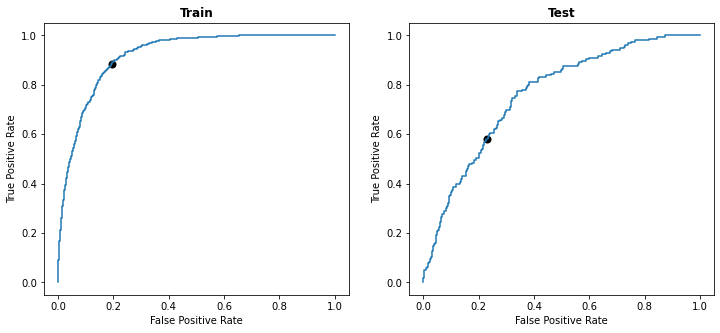

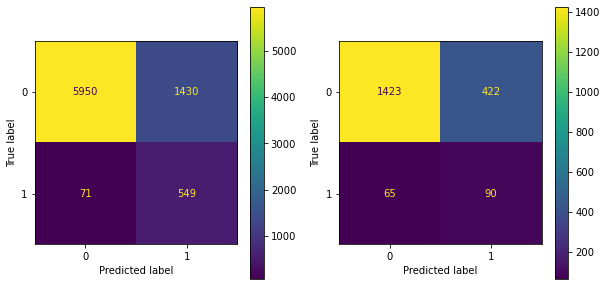

In [972]:
pipe_lgbm = best_threshold(X_train, X_test, y_train, y_test, 
                            features, 10, 
                            lgbm_class, 0.2, 0.8)


In [ ]:
# overfitting important

### Bayesian optimization

In [800]:
def bo_params_lightgbm(learning_rate,
            num_leaves,
            colsample_bytree,
            subsample,
            max_depth,
            reg_alpha, 
            reg_lambda,
            min_split_gain,
            min_child_weight):
    
    params = {
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'max_depth': int(max_depth),
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda, 
        'min_split_gain': min_split_gain, 
        'min_child_weight': min_child_weight,}
    
    clf = LGBMClassifier(n_estimators=150,
        class_weight=class_weights,
        learning_rate=params['learning_rate'],
        num_leaves=params['num_leaves'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        max_depth=params['max_depth'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain'], 
        min_child_weight=params['min_child_weight'])
    score = clf_result(clf,  X_train, y_train, 5)
    return score

In [801]:
import bayes_opt
from bayes_opt import BayesianOptimization
rf_bo_lightgbm = BayesianOptimization(bo_params_lightgbm, {
        'learning_rate': [0.01, 0.1],
        'num_leaves': [20, 40],
        'colsample_bytree': [0.5, 1],
        'subsample': [0.5, 1],
        'max_depth': [5, 10],
        'reg_alpha': [0.01, 0.1],
        'reg_lambda': [0.01, 0.1], 
        'min_split_gain': [0.01, 0.1],
        'min_child_weight': [30, 50]})

In [802]:
results = rf_bo_lightgbm.maximize(n_iter=40, init_points=10, acq='ei')

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------



Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument



| 1         | 0.7474    | 0.6689    | 0.07972   | 7.057     | 41.9      | 0.03117   | 39.09     | 0.08091   | 0.02463   | 0.811     |
| 2         | 0.7548    | 0.5249    | 0.03134   | 9.575     | 37.85     | 0.0227    | 24.23     | 0.06439   | 0.08432   | 0.8809    |
| 3         | 0.7462    | 0.6897    | 0.09972   | 5.046     | 36.69     | 0.04916   | 39.94     | 0.04332   | 0.02764   | 0.7434    |
| 4         | 0.7408    | 0.6164    | 0.09028   | 9.393     | 34.53     | 0.0429    | 20.56     | 0.08527   | 0.08034   | 0.72      |
| 5         | 0.7538    | 0.5723    | 0.03612   | 7.43      | 47.1      | 0.02834   | 22.05     | 0.05382   | 0.04524   | 0.8777    |
| 6         | 0.7523    | 0.9403    | 0.07232   | 5.016     | 47.14     | 0.0562    | 23.07     | 0.06724   | 0.04648   | 0.6076    |
| 7         | 0.7444    | 0.6193    | 0.07372   | 9.061     | 31.84     | 0.03236   | 34.0      | 0.05371   | 0.07072   | 0.6814    |
| 8         | 0.756     | 0.9357    | 0.02197   | 7.263     | 

In [ ]:
  0.8544    | 0.07149   | 8.804     | 37.43     | 0.07638   | 29.02     | 0.08469   | 0.08061   | 0.7983 

In [833]:
lgbm_opt = LGBMClassifier(
            nthread=4,
            n_estimators=150,
            learning_rate=0.07149 ,
            num_leaves=29,
            colsample_bytree=0.8544 ,
            subsample=0.7983,
            max_depth=9,
            reg_alpha=0.08469,
            reg_lambda=0.08061,
            min_split_gain=0.07638 ,
            min_child_weight=37.43,
            silent=-1,
            verbose=-1, 
            class_weight=class_weights,)

   folds  fit_time  score_time  validation_score  train_score
0    0.0  1.483884    0.025569          0.771680     0.985187
1    1.0  1.789595    0.037293          0.691122     0.984499
2    2.0  1.524027    0.027190          0.751923     0.985006
3    3.0  1.453552    0.023459          0.746678     0.985187
4    4.0  1.073846    0.021625          0.718835     0.986610
5    5.0  1.060996    0.022274          0.767834     0.984822
6    6.0  1.207791    0.024023          0.779351     0.985283
7    7.0  1.356271    0.024514          0.734461     0.985238
8    8.0  1.408263    0.022676          0.749847     0.986075
9    9.0  1.197482    0.022657          0.722200     0.982895
10  mean  1.355571    0.025128          0.743393     0.985080
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1

Best threshold:	0.5473684210526317

roc_auc train: 	0.9836677157094151 
roc_auc test: 	0.7601503627939505
Cost train : 	8.57500000000000

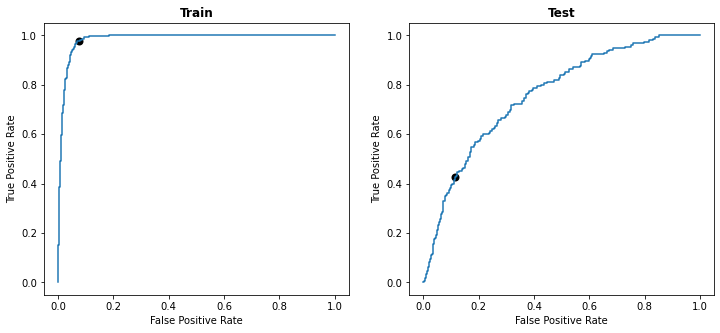

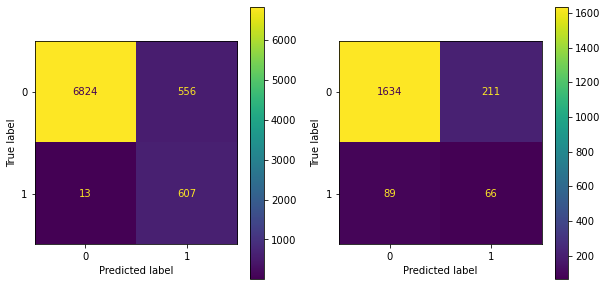

In [835]:
features = X_train.columns
pipe_lgbm_opt = best_threshold(X_train, X_test, y_train, y_test, 
                            features, 10, 
                            lgbm_opt, 0.2, 0.8)

In [793]:
lgbm_opt2 = LGBMClassifier(
            n_estimators=150,
            learning_rate=0.07149 ,
            num_leaves=29,
            colsample_bytree=0.8544 ,
            subsample=0.7983,
            max_depth=9,
            reg_alpha=0.008469,
            reg_lambda=0.008061,
            min_split_gain=0.07638 ,
            min_child_weight=37.43,
            silent=-1,
            verbose=-1, 
            class_weight='balanced')

In [973]:
features = X_train_full.columns

   folds    fit_time  score_time  validation_score  train_score
0    0.0  165.254946    1.282511          0.781407     0.833204
1    1.0  165.077107    1.456571          0.786098     0.833021
2    2.0  159.651028    1.664542          0.783592     0.833317
3    3.0  162.178918    1.075528          0.778722     0.833360
4    4.0  148.707089    1.455435          0.784872     0.833432
5    5.0  147.833803    1.239595          0.783548     0.833154
6    6.0  147.286831    1.524736          0.784489     0.832926
7    7.0  153.330989    3.236783          0.785438     0.833064
8    8.0  156.996454    1.194689          0.782811     0.832815
9    9.0  151.772555    1.697014          0.785452     0.833646
10  mean  155.808972    1.582740          0.783643     0.833194

Best threshold:	0.5157894736842106

roc_auc train: 	0.8290751747229166 
roc_auc test: 	0.784472591191919
Cost train : 	43.02798723603179
Cost test: 	48.69272543982309


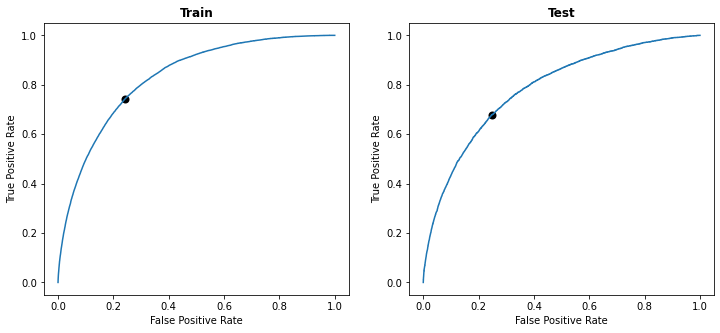

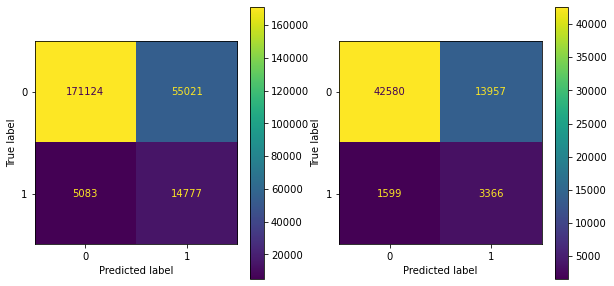

In [794]:
pipe_lgbm_opt2 = best_threshold(X_train_full, X_test_full, y_train_full, y_test_full, 
                            features, 10, 
                            lgbm_opt2, 0.4, 0.6)

,feature,importance
255,PAYMENT_RATE,169
31,EXT_SOURCE_1,157
32,EXT_SOURCE_2,144
33,EXT_SOURCE_3,135
10,DAYS_BIRTH,93
589,APPROVED_CNT_PAYMENT_MEAN,74
641,INSTAL_DPD_MEAN,73
7,AMT_ANNUITY,73
11,DAYS_EMPLOYED,60
6,AMT_CREDIT,51


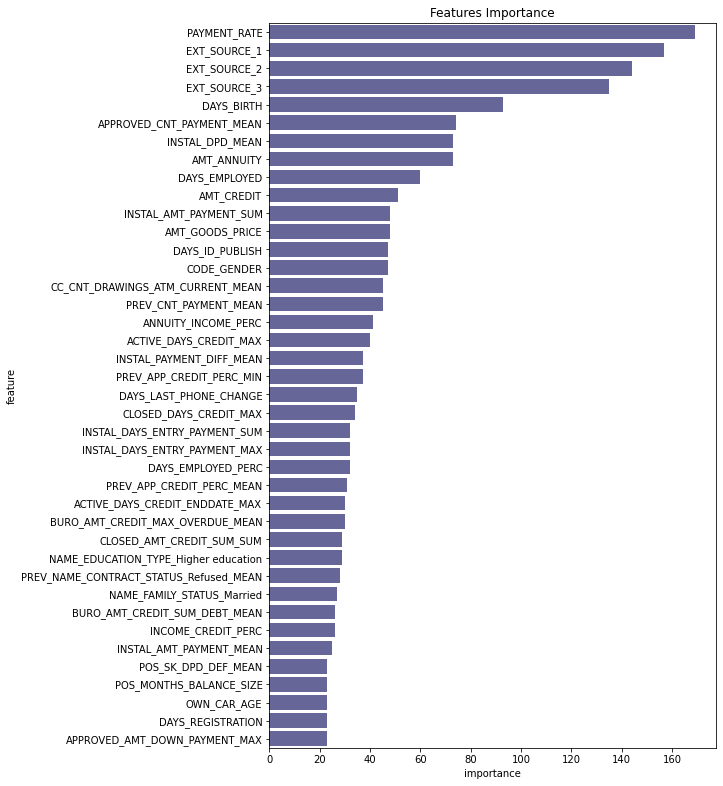

In [974]:
features_importance(features, pipe_lgbm_opt2, 40)

In [975]:
roc_auc_score(y, pipe_lgbm_opt2.predict_proba(X)[: , 1])

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.


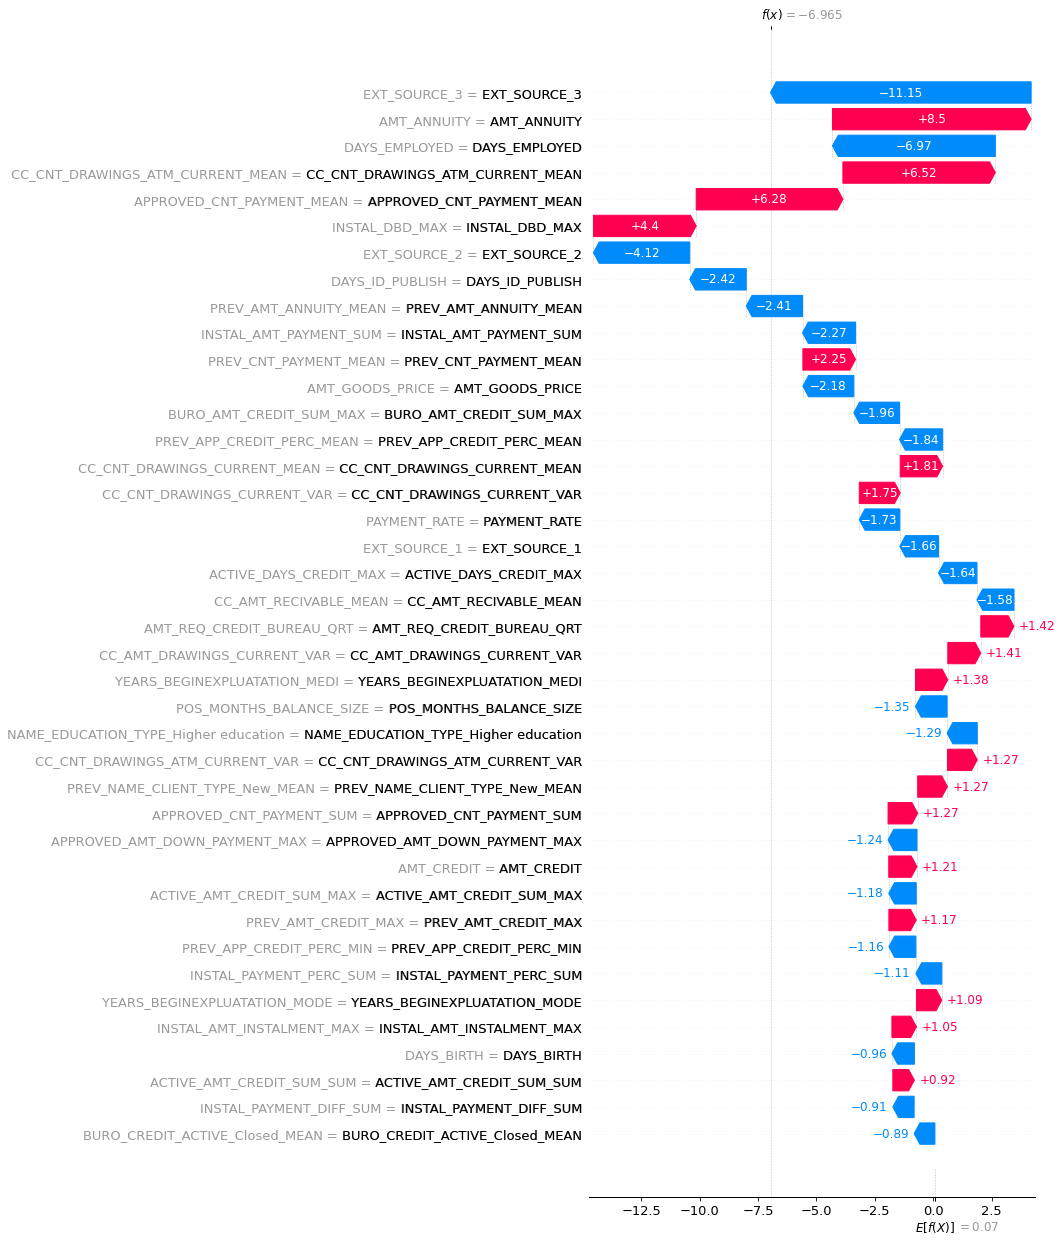

In [980]:
local_features(X_train_full, X_test_full, y_train_full, 100, pipe_lgbm_opt2, 40)

# Fin